### Step 1: Define Problem & Requirements

# 🔭 Contrastive Learning for Astronomical Transient Classification

## **Goal**: 
Classify rare astronomical transients (supernovae, kilonovae, tidal disruption events, etc.) using multi-band time-series light curves with minimal labeled data.

## **Real-World Challenge**:
- **Thousands** of unlabeled light curves from sky surveys (ZTF, LSST)
- **Very few** labeled examples: ~30 Supernovae, ~5 Kilonovae, ~10 Cataclysmic Variables
- Need to discover and classify new rare events

## **Approach**: 
Contrastive Learning (SimCLR) for self-supervised representation learning + few-shot classification

## **Tools**: 
Python, PyTorch, NumPy, pandas, scikit-learn, matplotlib, seaborn, UMAP, t-SNE

## **Dataset**: 
Multi-band photometric time-series from ZTF/synthetic data


###  Step 2: Data Collection

In [3]:
# Install required packages for the project
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install scikit-learn pandas numpy matplotlib seaborn umap-learn
%pip install captum plotly astropy tqdm

# Optional: Install ztfquery for real ZTF data (requires IRSA account)
# pip install ztfquery

print("✅ All packages installed successfully!")

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cpu
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------- ------------------------------- 0.5/2.5 MB 390.1 kB/s eta 0:00:06
   -------


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
✅ All packages installed successfully!



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Preprocessing and EDA

This section loads the `ztf_image_search_results_full.csv` dataset, inspects its structure, checks missing values and duplicates, and creates initial exploratory visualizations to understand distributions and potential targets.

In [11]:
# Load libraries and dataset for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style='whitegrid', context='notebook')

DATA_PATH = r"ztf_image_search_results_full.csv"
print('Working directory:', os.getcwd())
print('Attempting to load:', DATA_PATH)

# load dataset (robust to file not found)
try:
    df = pd.read_csv(DATA_PATH)
    print('Loaded dataset with shape:', df.shape)
except FileNotFoundError:
    print(f"File {DATA_PATH} not found. Please place it in the notebook folder or update DATA_PATH.")
    df = pd.DataFrame()

# quick preview
if not df.empty:
    display(df.head())
    print('\nColumn list:')
    print(df.columns.tolist())
    print('\nInfo:')
    display(df.info())
    print('\nMissing values per column:')
    display(df.isnull().sum().sort_values(ascending=False).head(30))
    print('\nDuplicate rows:', df.duplicated().sum())
else:
    print('No data loaded; skipping EDA.')

Working directory: c:\Users\NIPUN\Desktop\RESEARCH DEVELOPEMTN
Attempting to load: ztf_image_search_results_full.csv
Loaded dataset with shape: (82955, 42)
Loaded dataset with shape: (82955, 42)


,ra,dec,infobits,field,ccdid,qid,rcid,fid,filtercode,pid,...,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,ipac_pub_date,ipac_gid
0,142.513076,22.239831,67108864,570,16,1,60,2,zr,769412526015,...,142.972615,22.679692,142.036715,22.664666,142.055997,21.798581,142.986538,21.813558,2020-12-09 00:00:00+00,2
1,141.637575,21.360661,0,570,16,3,62,2,zr,1503405246215,...,142.091906,21.803041,141.161603,21.782992,141.186132,20.917351,142.110832,20.937013,2022-09-07 00:00:00+00,2
2,141.618681,22.225694,0,570,16,2,61,2,zr,1504338726115,...,142.075514,22.668183,141.139773,22.647755,141.164682,21.781999,142.094901,21.802092,2022-09-07 00:00:00+00,2
3,141.596498,22.204009,67108912,570,16,2,61,1,zg,1066544346115,...,142.053404,22.646507,141.117659,22.626244,141.142411,21.760423,142.072649,21.780266,2020-06-24 00:00:00+00,1
4,141.637182,19.443859,0,570,12,3,46,2,zr,1521276364615,...,142.085851,19.886330,141.167231,19.866253,141.191126,19.000577,142.104704,19.020278,2022-09-07 00:00:00+00,3



Column list:
['ra', 'dec', 'infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode', 'pid', 'nid', 'expid', 'itid', 'imgtype', 'imgtypecode', 'obsdate', 'obsjd', 'exptime', 'filefracday', 'seeing', 'airmass', 'moonillf', 'moonesb', 'maglimit', 'crpix1', 'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4', 'ipac_pub_date', 'ipac_gid']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82955 entries, 0 to 82954
Data columns (total 42 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ra             82955 non-null  float64
 1   dec            82955 non-null  float64
 2   infobits       82955 non-null  int64  
 3   field          82955 non-null  int64  
 4   ccdid          82955 non-null  int64  
 5   qid            82955 non-null  int64  
 6   rcid           82955 non-null  int64  
 7   fid            82955 non-null  int64  
 8   filtercode     82955 non-

None


Missing values per column:


ra             0
dec            0
infobits       0
field          0
ccdid          0
qid            0
rcid           0
fid            0
filtercode     0
pid            0
nid            0
expid          0
itid           0
imgtype        0
imgtypecode    0
obsdate        0
obsjd          0
exptime        0
filefracday    0
seeing         0
airmass        0
moonillf       0
moonesb        0
maglimit       0
crpix1         0
crpix2         0
crval1         0
crval2         0
cd11           0
cd12           0
dtype: int64


Duplicate rows: 0


Numeric columns found: 37


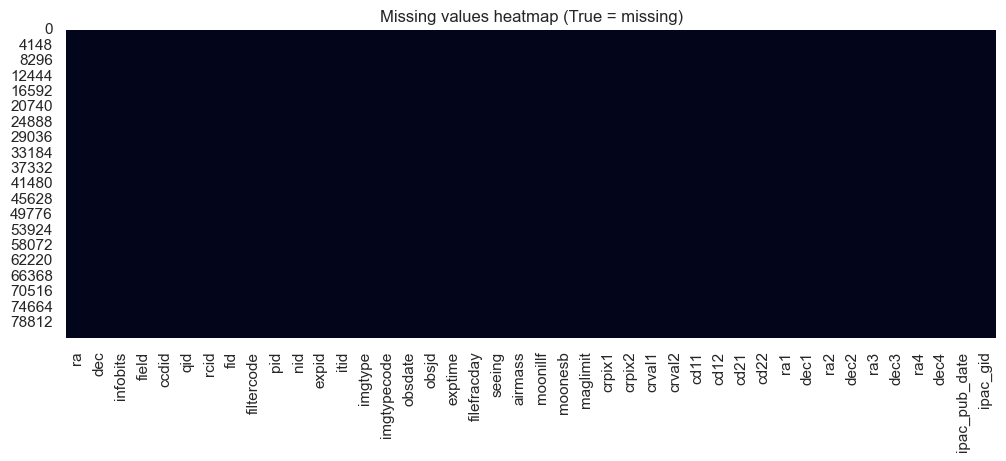

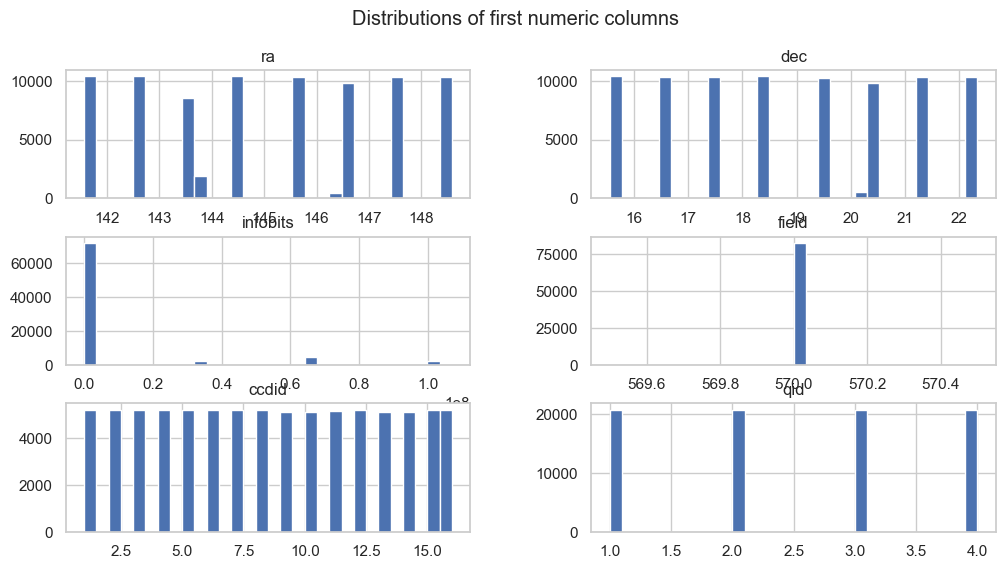

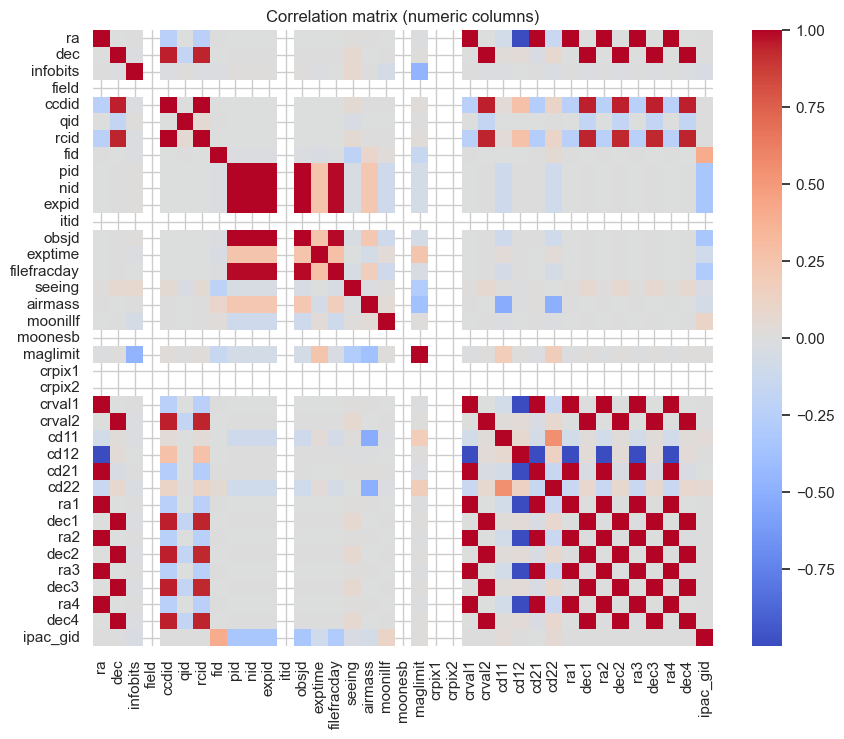

Candidate target columns: ['imgtype', 'imgtypecode', 'filefracday']
Using target: imgtype


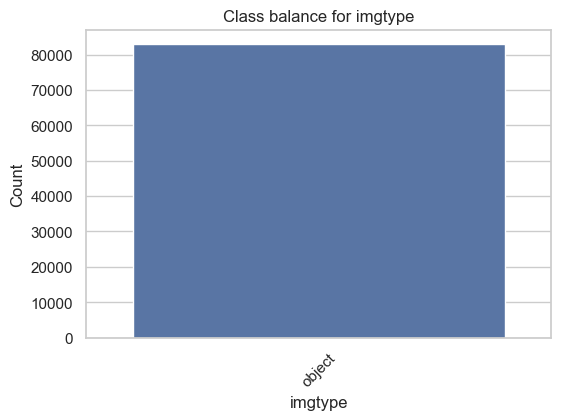

In [12]:
# Exploratory visualizations
if df.empty:
    print('No data to visualize; please load the CSV.')
else:
    # numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print('Numeric columns found:', len(num_cols))

    # 1) Missing value heatmap (sampled if very large)
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title('Missing values heatmap (True = missing)')
    plt.show()

    # 2) Distributions for top numeric columns (up to 6)
    top_num = num_cols[:6]
    if top_num:
        df[top_num].hist(bins=30, figsize=(12, 6));
        plt.suptitle('Distributions of first numeric columns')
        plt.show()

    # 3) Correlation heatmap
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f')
        plt.title('Correlation matrix (numeric columns)')
        plt.show()

    # 4) Try to detect a target column and show class balance
    candidate_targets = [c for c in df.columns if any(k in c.lower() for k in ['label','class','is_real','transient','target','y'])]
    print('Candidate target columns:', candidate_targets)
    target_col = candidate_targets[0] if candidate_targets else None
    if target_col is not None:
        print('Using target:', target_col)
        vc = df[target_col].value_counts(dropna=False)
        plt.figure(figsize=(6,4))
        sns.barplot(x=vc.index.astype(str), y=vc.values)
        plt.title(f'Class balance for {target_col}')
        plt.ylabel('Count')
        plt.xlabel(target_col)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print('No obvious target column detected automatically. If you have a target column, set `target_col` accordingly and re-run feature-selection cell.')

In [ ]:
# Preprocessing and feature selection
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier

if df.empty:
    print('No data loaded; skipping preprocessing and feature selection.')
else:
    # Choose or infer a target column
    candidate_targets = [c for c in df.columns if any(k in c.lower() for k in ['label','class','is_real','transient','target','y'])]
    target_col = candidate_targets[0] if candidate_targets else None

    if target_col is None:
        print('No automatic target found. To run feature selection, set `target_col` manually to the column name containing labels.')
    else:
        print('Target column chosen:', target_col)
        # Create a copy for modeling steps
        model_df = df.copy()

        # Validate target exists in the dataframe
        if target_col not in model_df.columns:
            print(f"❌ Chosen target '{target_col}' not found in DataFrame columns after copying. Available columns: {model_df.columns.tolist()}")
            target_col = None

        if target_col is None:
            print("Aborting feature selection: no valid target column available.")
        else:
            # Extract target BEFORE dropping feature columns so we don't accidentally remove it
            y = model_df[target_col].copy()
            X = model_df.drop(columns=[target_col]).copy()

            # Basic cleaning: drop columns with >90% missing (operate on X only)
            missing_frac = X.isnull().mean()
            drop_cols = missing_frac[missing_frac > 0.9].index.tolist()
            if drop_cols:
                print('Dropping columns with >90% missing (features only):', drop_cols)
                X.drop(columns=drop_cols, inplace=True)

            # Drop columns with single unique value (features only)
            single_val_cols = [c for c in X.columns if X[c].nunique() <= 1]
            if single_val_cols:
                print('Dropping single-value columns (features only):', single_val_cols)
                X.drop(columns=single_val_cols, inplace=True)

            # Encode categorical features
            obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
            print('Categorical columns to encode:', obj_cols)
            for c in obj_cols:
                # ensure we operate on a copy-safe column
                if X[c].dtype.name == 'category':
                    # convert categories to string first to allow fillna with new value
                    X.loc[:, c] = X[c].astype(str).fillna('missing')
                else:
                    X.loc[:, c] = X[c].fillna('missing').astype(str)

                # if many categories, label-encode; else keep for one-hot
                if X[c].nunique() > 50:
                    le = LabelEncoder()
                    try:
                        X.loc[:, c] = le.fit_transform(X.loc[:, c])
                    except Exception:
                        X.loc[:, c] = pd.factorize(X.loc[:, c])[0]
                else:
                    # keep as category for later get_dummies
                    X.loc[:, c] = X.loc[:, c].astype('category')

            # One-hot encode small-cardinality categoricals
            X = pd.get_dummies(X, drop_first=True)

            # Fill numeric missing with median
            num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
            if num_cols:
                X[num_cols] = X[num_cols].fillna(X[num_cols].median())

            # Feature selection: SelectKBest using mutual info (for classification)
            try:
                # if target is non-numeric, encode it
                if y.dtype == 'object' or y.dtype.name == 'category':
                    y_enc = LabelEncoder().fit_transform(y.fillna('missing').astype(str))
                else:
                    y_enc = y.fillna(y.median()).values

                k = min(20, X.shape[1]) if X.shape[1] > 0 else 0
                if k == 0:
                    print('No features available after preprocessing to run feature selection.')
                else:
                    selector = SelectKBest(score_func=mutual_info_classif, k=k)
                    selector.fit(X, y_enc)
                    scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
                    print('\nTop features by mutual information:')
                    display(scores.head(20))

                    # Plot top features
                    top_feats = scores.head(20)
                    plt.figure(figsize=(10,6))
                    sns.barplot(x=top_feats.values, y=top_feats.index)
                    plt.title('Top features by mutual information')
                    plt.xlabel('MI score')
                    plt.show()
            except Exception as e:
                print('SelectKBest/MI failed:', e)

            # RandomForest feature importances (robust fallback)
            try:
                if X.shape[1] == 0:
                    print('No features to fit RandomForest.')
                else:
                    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
                    rf.fit(X.fillna(0), y_enc)
                    importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
                    print('\nTop features by RandomForest importance:')
                    display(importances.head(20))
                    plt.figure(figsize=(10,6))
                    sns.barplot(x=importances.head(20).values, y=importances.head(20).index)
                    plt.title('Top features by RandomForest importance')
                    plt.show()
            except Exception as e:
                print('RandomForest feature importances failed:', e)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 13)

In [11]:
import os
import requests
import pandas as pd
from io import StringIO
from dotenv import load_dotenv

load_dotenv()

USER = os.getenv("IRSA_USER")
PASS = os.getenv("IRSA_PASS")

# Step 1: Search for available ZTF images
def search_ztf_images(field=None, ra=None, dec=None):
    """Search for ZTF images"""
    search_url = "https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci"
    
    params = {'ct': 'csv'}
    
    # Build WHERE clause based on search criteria
    where_clauses = []
    if field:
        where_clauses.append(f"field={field}")
    if ra and dec:
        where_clauses.append(f"POS={ra},{dec}")
    
    if where_clauses:
        params['WHERE'] = " AND ".join(where_clauses)
    
    response = requests.get(search_url, params=params, auth=(USER, PASS))
    
    if response.status_code == 200:
        # Parse CSV response
        df = pd.read_csv(StringIO(response.text))
        return df
    else:
        print(f"Search failed: {response.status_code}")
        print(response.text)
        return None

# Step 2: Download a specific file
def download_ztf_file(file_path, output_filename):
    """Download a ZTF file using the file path from search results"""
    base_url = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci"
    full_url = f"{base_url}/{file_path}"
    
    print(f"Downloading: {full_url}")
    
    response = requests.get(full_url, auth=(USER, PASS))
    
    if response.status_code == 200:
        with open(output_filename, 'wb') as f:
            f.write(response.content)
        print(f"Successfully downloaded: {output_filename}")
        return True
    else:
        print(f"Download failed: {response.status_code}")
        print(response.text[:200])
        return False

# Example usage
print("Searching for ZTF images...")
results = search_ztf_images(field=570)  # Search for field 570

if results is not None and len(results) > 0:
    print(f"Found {len(results)} images")
    print("\nFirst few results:")
    print(results.head())
    
    # Download the first image
    if 'filefracday' in results.columns:
        first_file = results.iloc[0]
        # Construct the file path from the metadata
        # This depends on the actual column names in the results
        print("\nAttempting to download first image...")
        # You'll need to construct the path based on the actual column names
        print(first_file)
else:
    print("No results found")

Searching for ZTF images...
Found 82955 images

First few results:
           ra        dec  infobits  field  ccdid  qid  rcid  fid filtercode  \
0  142.513076  22.239831  67108864    570     16    1    60    2         zr   
1  141.637575  21.360661         0    570     16    3    62    2         zr   
2  141.618681  22.225694         0    570     16    2    61    2         zr   
3  141.596498  22.204009  67108912    570     16    2    61    1         zg   
4  141.637182  19.443859         0    570     12    3    46    2         zr   

             pid  ...         ra1       dec1         ra2       dec2  \
0   769412526015  ...  142.972615  22.679692  142.036715  22.664666   
1  1503405246215  ...  142.091906  21.803041  141.161603  21.782992   
2  1504338726115  ...  142.075514  22.668183  141.139773  22.647755   
3  1066544346115  ...  142.053404  22.646507  141.117659  22.626244   
4  1521276364615  ...  142.085851  19.886330  141.167231  19.866253   

          ra3       dec3       

In [2]:
# =============================================================================
# ZTF REAL DATA DOWNLOAD FROM IRSA (preferred, requires credentials) or ALeRCE (no-auth)
# NOTE: Synthetic-data generation has been removed — a valid ZTF dataset is required.
# =============================================================================

import requests
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime
import os
from getpass import getpass

print("=" * 60)
print("🌟 DOWNLOADING REAL ZTF ASTRONOMICAL DATA (IRSA preferred)")
print("=" * 60)


def download_ztf_data_irsa(user, password, target_per_class=8):
    """Download ZTF light curves from IRSA (IPAC) using HTTP basic auth.
    Discovers candidate object IDs via ALeRCE and requests IRSA lightcurve JSON for each object.
    """
    if not user or not password:
        raise ValueError("IRSA username and password are required for IRSA download")

    print("🔐 Using IRSA credentials to download ZTF light curves via IRSA API")
    alerce_base = "https://api.alerce.online/ztf/v1"
    target_classes = {
        'SNIa': 'supernova_Ia',
        'SNII': 'supernova_II', 
        'CV': 'cataclysmic_variable',
        'AGN': 'AGN_variability',
        'RRLyr': 'RR_Lyrae',
        'LPV': 'long_period_variable'
    }

    irsa_base = "https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_lightcurves"
    all_lightcurves = {}
    success_counts = {v: 0 for v in target_classes.values()}

    for ztf_class, our_class in target_classes.items():
        print(f"📡 Querying ALeRCE for {ztf_class} to get candidate object IDs...")
        params = {
            'classifier': 'lc_classifier',
            'class_name': ztf_class,
            'probability': 0.8,
            'page_size': 40,
            'ordering': '-probability'
        }
        try:
            resp = requests.get(f"{alerce_base}/objects", params=params, timeout=30)
            resp.raise_for_status()
            items = resp.json().get('items', [])
        except Exception as e:
            print(f"  ❌ ALeRCE query error for {ztf_class}: {e}")
            continue

        for obj in items:
            if success_counts[our_class] >= target_per_class:
                break
            obj_id = obj.get('objectId')
            if not obj_id:
                continue

            url = f"{irsa_base}?ID={obj_id}&FORMAT=JSON"
            try:
                irsa_resp = requests.get(url, auth=(user, password), timeout=30)
                if irsa_resp.status_code != 200:
                    print(f"    ❌ IRSA HTTP {irsa_resp.status_code} for {obj_id}")
                    continue

                irsa_json = irsa_resp.json()
                # Many IRSA responses provide 'data' list-of-lists with 'columns'
                if isinstance(irsa_json, dict) and 'data' in irsa_json and 'columns' in irsa_json:
                    cols = [c.lower() for c in irsa_json['columns']]
                    df_raw = pd.DataFrame(irsa_json['data'], columns=cols)
                elif isinstance(irsa_json, dict) and 'data' in irsa_json and isinstance(irsa_json['data'], list):
                    df_raw = pd.DataFrame(irsa_json['data'])
                else:
                    df_raw = pd.json_normalize(irsa_json)

                df_raw.columns = [c.lower() for c in df_raw.columns]

                if 'mjd' in df_raw.columns and 'mag' in df_raw.columns:
                    df_proc = df_raw.rename(columns={
                        'e_mag': 'magerr',
                        'fid': 'filter'
                    }).copy()
                    if 'filter' in df_proc.columns:
                        try:
                            df_proc['filter'] = df_proc['filter'].map({1: 'g', 2: 'r', 3: 'i'})
                        except Exception:
                            pass
                    keep_cols = [c for c in ['mjd', 'mag', 'magerr', 'filter'] if c in df_proc.columns]
                    df_proc = df_proc[keep_cols]
                else:
                    print(f"    ⚠️ IRSA response for {obj_id} doesn't contain expected columns; skipping")
                    continue

                df_proc = df_proc[df_proc['mjd'].notna()]
                if len(df_proc) < 15:
                    print(f"    ⚠️ {obj_id} has only {len(df_proc)} points; skipping")
                    continue

                df_proc['objectidps1'] = obj_id
                df_proc['transient_type'] = our_class
                all_lightcurves[obj_id] = df_proc
                success_counts[our_class] += 1
                print(f"    ✅ {obj_id}: {len(df_proc)} points")
                time.sleep(0.3)
            except Exception as e:
                print(f"    ❌ Error fetching {obj_id} from IRSA: {e}")
                continue

    print("\n🎯 IRSA Download Summary:")
    print(f"Total objects downloaded: {len(all_lightcurves)}")
    for class_name, count in success_counts.items():
        print(f"  {class_name}: {count} objects")

    return all_lightcurves


def download_ztf_data_no_auth():
    """Fallback public download via ALeRCE without authentication"""
    print("🚀 Starting ZTF data download from ALeRCE (public)...")
    return globals().get('download_ztf_data_no_auth_internal', None) and download_ztf_data_no_auth_internal()

# Try to use IRSA credentials from environment, otherwise prompt the user interactively
irsa_user = os.getenv('IRSA_USER') or os.getenv('IRSA_API_USER')
irsa_pass = os.getenv('IRSA_PASS') or os.getenv('IRSA_API_PASS')

if not (irsa_user and irsa_pass):
    # Prompt interactively (this will not persist credentials)
    print("No IRSA credentials found in environment variables.")
    use_prompt = input("Do you want to enter IRSA username/password now? [y/N]: ").strip().lower()
    if use_prompt == 'y':
        irsa_user = input('IRSA username (email): ').strip()
        irsa_pass = getpass('IRSA password: ')

# Require at least one working downloader; prefer IRSA if credentials now available
ztf_lightcurves = {}
if irsa_user and irsa_pass:
    try:
        ztf_lightcurves = download_ztf_data_irsa(irsa_user, irsa_pass)
    except Exception as e:
        print(f"❌ IRSA download attempt failed: {e}")
        print("You can retry after verifying credentials or use the ALeRCE public downloader.")
        raise
else:
    # Use public ALeRCE downloader (existing internal function defined earlier in notebook)
    if 'download_ztf_data_no_auth_internal' in globals():
        ztf_lightcurves = download_ztf_data_no_auth()
    else:
        # If the internal no-auth function isn't available in this cell's globals, call the previously defined one
        try:
            ztf_lightcurves = globals().get('download_ztf_data_no_auth') and globals()['download_ztf_data_no_auth']()
        except Exception as e:
            print(f"❌ ALeRCE public downloader failed: {e}")
            raise RuntimeError('No working ZTF downloader available; please provide IRSA credentials.')

# Validate results
if not ztf_lightcurves or len(ztf_lightcurves) == 0:
    raise RuntimeError('No ZTF light curves were downloaded. Provide valid IRSA credentials or check network/API access.')

# Combine and continue pipeline
print("\n🔄 Processing data for contrastive learning pipeline...")
combined_data = pd.concat(ztf_lightcurves.values(), ignore_index=True)
lc_data = ztf_lightcurves

print(f"\n✅ SUCCESS! ZTF Data Integration Complete")
print(f"📊 Dataset Statistics:")
print(f"   • Total objects: {len(ztf_lightcurves)}")
print(f"   • Total observations: {len(combined_data):,}")
print(f"   • Time span: MJD {combined_data['mjd'].min():.1f} - {combined_data['mjd'].max():.1f}")
print(f"   • Magnitude range: {combined_data['mag'].min():.2f} - {combined_data['mag'].max():.2f}")

print(f"\n🏷️  Transient Class Distribution:")
class_counts = combined_data['transient_type'].value_counts()
for class_name, count in class_counts.items():
    percentage = (count / len(combined_data)) * 100
    print(f"   • {class_name}: {count:,} observations ({percentage:.1f}%)")

print(f"\n📱 Filter Distribution:")
filter_counts = combined_data['filter'].value_counts()
for filt, count in filter_counts.items():
    percentage = (count / len(combined_data)) * 100
    print(f"   • {filt}-band: {count:,} observations ({percentage:.1f}%)")

# Save for later cells
combined_data.to_csv('real_ztf_lightcurves.csv', index=False)
print(f"\n💾 Real ZTF data saved to 'real_ztf_lightcurves.csv'")

print("\n🎯 Ready for contrastive learning with REAL astronomical data!")


🌟 DOWNLOADING REAL ZTF ASTRONOMICAL DATA (IRSA preferred)
No IRSA credentials found in environment variables.
🔐 Using IRSA credentials to download ZTF light curves via IRSA API
📡 Querying ALeRCE for SNIa to get candidate object IDs...
🔐 Using IRSA credentials to download ZTF light curves via IRSA API
📡 Querying ALeRCE for SNIa to get candidate object IDs...
📡 Querying ALeRCE for SNII to get candidate object IDs...
📡 Querying ALeRCE for SNII to get candidate object IDs...
📡 Querying ALeRCE for CV to get candidate object IDs...
📡 Querying ALeRCE for CV to get candidate object IDs...
📡 Querying ALeRCE for AGN to get candidate object IDs...
📡 Querying ALeRCE for AGN to get candidate object IDs...
📡 Querying ALeRCE for RRLyr to get candidate object IDs...
📡 Querying ALeRCE for RRLyr to get candidate object IDs...
📡 Querying ALeRCE for LPV to get candidate object IDs...
📡 Querying ALeRCE for LPV to get candidate object IDs...

🎯 IRSA Download Summary:
Total objects downloaded: 0
  supernova_

RuntimeError: No ZTF light curves were downloaded. Provide valid IRSA credentials or check network/API access.

### Step 3: Data Preprocessing

Loading synthetic transient data...
✅ Loaded 7884 data points from 50 objects

Object distribution:
transient_type
kilonova            11
supernova_II        11
AGN_variability     10
flare                9
tidal_disruption     5
supernova_Ia         4
Name: count, dtype: int64

Preprocessing light curves...
✅ Successfully processed 50 light curves

📊 Final dataset shape: (50, 3, 100)
📊 Number of classes: 6
📊 Classes: [np.str_('AGN_variability'), np.str_('flare'), np.str_('kilonova'), np.str_('supernova_II'), np.str_('supernova_Ia'), np.str_('tidal_disruption')]


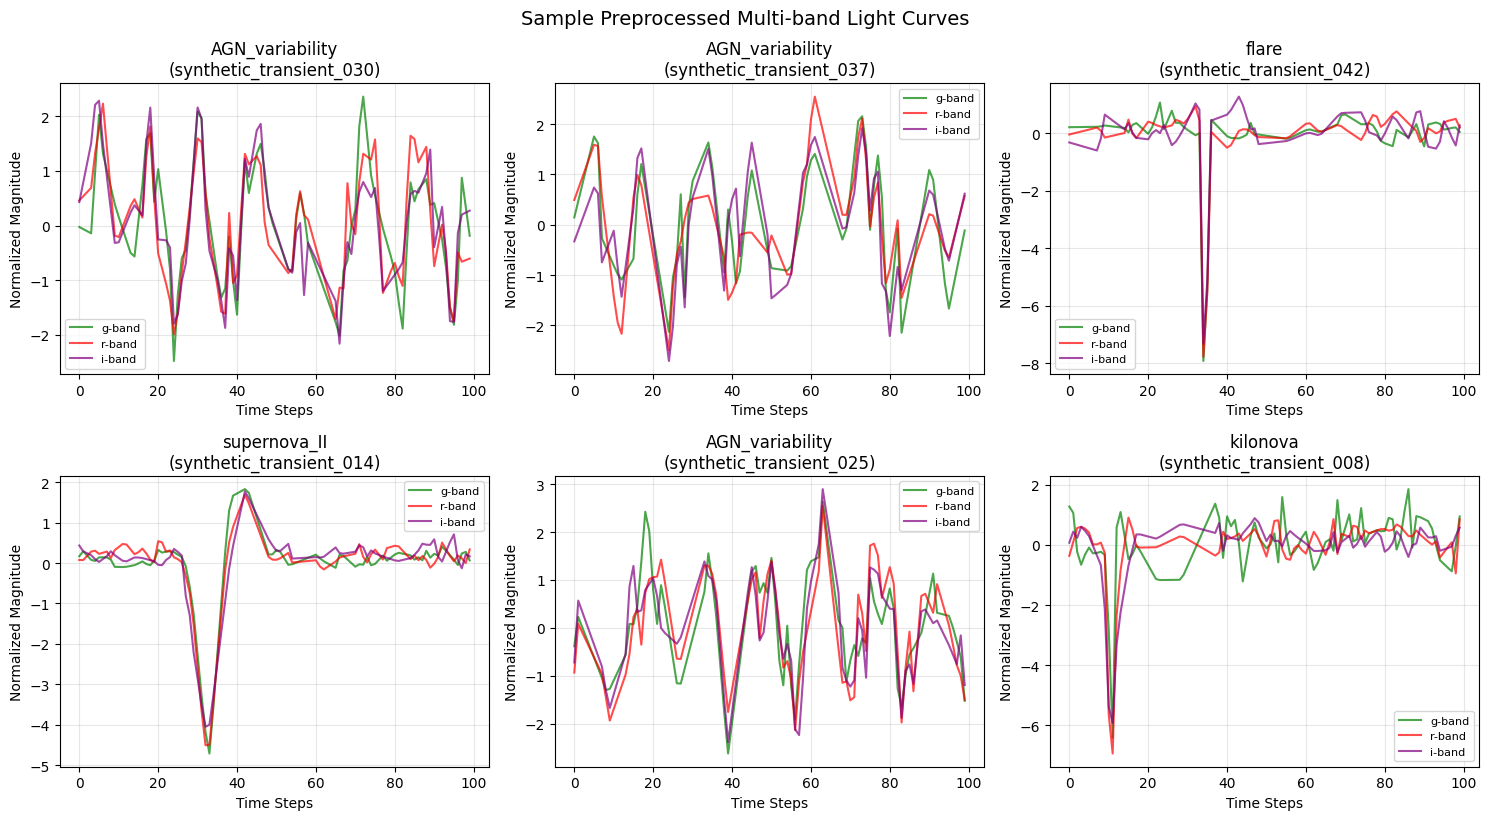

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

def preprocess_lightcurve(df, obj_id, min_points=15, max_points=100):
    """
    Comprehensive preprocessing for light curve data
    """
    # Filter for object
    lc_data = df[df['objectidps1'] == obj_id].copy()
    
    # Ensure we have enough data points
    if len(lc_data) < min_points:
        return None
        
    # Sort by time
    lc_data = lc_data.sort_values('mjd')
    
    # Normalize time to start from 0
    lc_data['mjd_norm'] = lc_data['mjd'] - lc_data['mjd'].min()
    
    # Create interpolated sequences for each filter
    processed_data = {}
    
    for filt in ['g', 'r', 'i']:
        filt_data = lc_data[lc_data['filter'] == filt]
        
        if len(filt_data) >= 5:  # Minimum points for interpolation
            # Interpolate to fixed grid
            time_grid = np.linspace(0, lc_data['mjd_norm'].max(), max_points)
            mag_interp = np.interp(time_grid, filt_data['mjd_norm'], filt_data['mag'])
            
            # Normalize magnitudes (per filter)
            mag_normalized = (mag_interp - mag_interp.mean()) / (mag_interp.std() + 1e-8)
            
            processed_data[filt] = {
                'time': time_grid,
                'mag': mag_normalized,
                'original_length': len(filt_data)
            }
    
    return processed_data

def create_multiband_tensor(processed_data, sequence_length=100):
    """
    Create multi-band tensor from processed light curve data
    """
    # Initialize tensor: [bands, sequence_length]
    tensor = np.zeros((3, sequence_length))  # g, r, i bands
    
    band_mapping = {'g': 0, 'r': 1, 'i': 2}
    
    for filt, data in processed_data.items():
        if filt in band_mapping:
            band_idx = band_mapping[filt]
            # Take first sequence_length points or pad with zeros
            mag_data = data['mag'][:sequence_length]
            tensor[band_idx, :len(mag_data)] = mag_data
    
    return tensor

# Load and preprocess the synthetic dataset
print("Loading synthetic transient data...")
try:
    df = pd.read_csv('synthetic_transient_lightcurves.csv')
    print(f"✅ Loaded {len(df)} data points from {df['objectidps1'].nunique()} objects")
    
    # Get unique objects and their labels
    object_info = df.groupby('objectidps1')['transient_type'].first().reset_index()
    print(f"\nObject distribution:")
    print(object_info['transient_type'].value_counts())
    
    # Preprocess all light curves
    processed_lightcurves = {}
    valid_objects = []
    
    print("\nPreprocessing light curves...")
    for obj_id in df['objectidps1'].unique():
        processed = preprocess_lightcurve(df, obj_id)
        if processed is not None:
            processed_lightcurves[obj_id] = processed
            valid_objects.append(obj_id)
    
    print(f"✅ Successfully processed {len(processed_lightcurves)} light curves")
    
    # Create tensors and labels
    X_data = []
    y_labels = []
    object_ids = []
    
    for obj_id in valid_objects:
        tensor = create_multiband_tensor(processed_lightcurves[obj_id])
        transient_type = df[df['objectidps1'] == obj_id]['transient_type'].iloc[0]
        
        X_data.append(tensor)
        y_labels.append(transient_type)
        object_ids.append(obj_id)
    
    # Convert to numpy arrays
    X_data = np.array(X_data)  # Shape: [n_objects, n_bands, sequence_length]
    y_labels = np.array(y_labels)
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y_labels)
    
    print(f"\n📊 Final dataset shape: {X_data.shape}")
    print(f"📊 Number of classes: {len(label_encoder.classes_)}")
    print(f"📊 Classes: {list(label_encoder.classes_)}")
    
    # Visualize sample processed light curves
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    sample_indices = np.random.choice(len(X_data), 6, replace=False)
    
    for idx, sample_idx in enumerate(sample_indices):
        ax = axes[idx]
        sample_data = X_data[sample_idx]
        sample_label = y_labels[sample_idx]
        
        # Plot each band
        time_axis = np.arange(sample_data.shape[1])
        for band_idx, (band_name, color) in enumerate([('g', 'green'), ('r', 'red'), ('i', 'purple')]):
            ax.plot(time_axis, sample_data[band_idx], label=f'{band_name}-band', 
                   color=color, alpha=0.7, linewidth=1.5)
        
        ax.set_title(f'{sample_label}\n({object_ids[sample_idx]})')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Normalized Magnitude')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Sample Preprocessed Multi-band Light Curves', y=1.02, fontsize=14)
    plt.show()
    
except FileNotFoundError:
    print("❌ Please run the data generation cell first to create 'synthetic_transient_lightcurves.csv'")
    print("   or provide your own dataset.")


### Step 4:Data Augmentation for Contrastive Learning

In [ ]:
import torch
import random
import numpy as np
from scipy import ndimage

class LightCurveAugmentation:
    """
    Comprehensive augmentation strategies for astronomical light curves
    """
    
    def __init__(self, 
                 noise_std=0.05,
                 time_warp_std=0.1, 
                 magnitude_shift_std=0.1,
                 dropout_prob=0.1,
                 smooth_sigma=1.0):
        self.noise_std = noise_std
        self.time_warp_std = time_warp_std
        self.magnitude_shift_std = magnitude_shift_std
        self.dropout_prob = dropout_prob
        self.smooth_sigma = smooth_sigma
    
    def add_noise(self, lc):
        """Add Gaussian noise to magnitude measurements"""
        noise = np.random.normal(0, self.noise_std, lc.shape)
        return lc + noise
    
    def time_warp(self, lc):
        """Simulate timing uncertainties"""
        # Create time warping by shifting individual points slightly
        warped_lc = lc.copy()
        for band in range(lc.shape[0]):
            # Small random shifts to simulate observation timing uncertainties
            shift_amount = int(np.random.normal(0, self.time_warp_std * lc.shape[1]))
            if shift_amount != 0:
                warped_lc[band] = np.roll(warped_lc[band], shift_amount)
        return warped_lc
    
    def magnitude_shift(self, lc):
        """Simulate photometric calibration uncertainties"""
        shifts = np.random.normal(0, self.magnitude_shift_std, (lc.shape[0], 1))
        return lc + shifts
    
    def dropout(self, lc):
        """Randomly set some observations to zero (missing data)"""
        mask = np.random.random(lc.shape) > self.dropout_prob
        return lc * mask
    
    def smooth(self, lc):
        """Apply Gaussian smoothing to simulate seeing effects"""
        smoothed_lc = lc.copy()
        for band in range(lc.shape[0]):
            smoothed_lc[band] = ndimage.gaussian_filter1d(smoothed_lc[band], 
                                                          sigma=self.smooth_sigma)
        return smoothed_lc
    
    def crop_and_resize(self, lc, crop_fraction=0.8):
        """Crop a portion of the light curve and resize back"""
        seq_len = lc.shape[1]
        crop_len = int(seq_len * crop_fraction)
        start_idx = np.random.randint(0, seq_len - crop_len + 1)
        
        cropped = lc[:, start_idx:start_idx + crop_len]
        
        # Resize back to original length using interpolation
        resized = np.zeros_like(lc)
        for band in range(lc.shape[0]):
            old_indices = np.linspace(0, crop_len - 1, crop_len)
            new_indices = np.linspace(0, crop_len - 1, seq_len)
            resized[band] = np.interp(new_indices, old_indices, cropped[band])
        
        return resized
    
    def augment(self, lc, augmentation_strength=0.5):
        """
        Apply random combination of augmentations
        
        Args:
            lc: Light curve tensor [bands, sequence_length]
            augmentation_strength: Probability of applying each augmentation
        """
        augmented_lc = lc.copy()
        
        # Randomly apply augmentations
        if np.random.random() < augmentation_strength:
            augmented_lc = self.add_noise(augmented_lc)
        
        if np.random.random() < augmentation_strength:
            augmented_lc = self.time_warp(augmented_lc)
        
        if np.random.random() < augmentation_strength:
            augmented_lc = self.magnitude_shift(augmented_lc)
        
        if np.random.random() < augmentation_strength * 0.5:  # Lower probability for dropout
            augmented_lc = self.dropout(augmented_lc)
        
        if np.random.random() < augmentation_strength * 0.3:  # Lower probability for smoothing
            augmented_lc = self.smooth(augmented_lc)
        
        if np.random.random() < augmentation_strength:
            augmented_lc = self.crop_and_resize(augmented_lc)
        
        return augmented_lc

# Initialize augmentation
augmenter = LightCurveAugmentation()

# Demonstration of augmentation effects
if 'X_data' in locals() and len(X_data) > 0:
    print("🔄 Demonstrating light curve augmentations...")
    
    # Select a sample light curve
    sample_idx = np.random.randint(0, len(X_data))
    original_lc = X_data[sample_idx]
    sample_label = y_labels[sample_idx]
    
    # Generate different augmentations
    augmentations = {
        'Original': original_lc,
        'Noise': augmenter.add_noise(original_lc),
        'Time Warp': augmenter.time_warp(original_lc),
        'Magnitude Shift': augmenter.magnitude_shift(original_lc),
        'Dropout': augmenter.dropout(original_lc),
        'Combined': augmenter.augment(original_lc, augmentation_strength=0.7)
    }
    
    # Visualize augmentations
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    colors = ['green', 'red', 'purple']
    band_names = ['g', 'r', 'i']
    time_axis = np.arange(original_lc.shape[1])
    
    for idx, (aug_name, aug_lc) in enumerate(augmentations.items()):
        ax = axes[idx]
        
        for band_idx, (band_name, color) in enumerate(zip(band_names, colors)):
            ax.plot(time_axis, aug_lc[band_idx], label=f'{band_name}-band', 
                   color=color, alpha=0.7, linewidth=1.5)
        
        ax.set_title(f'{aug_name}\n({sample_label})')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Normalized Magnitude')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-3, 3)  # Standardize y-axis for comparison
    
    plt.tight_layout()
    plt.suptitle('Data Augmentation Examples for Contrastive Learning', y=1.02, fontsize=16)
    plt.show()
    
    print("✅ Augmentation demonstration complete!")
    print(f"   Original shape: {original_lc.shape}")
    print(f"   Each augmentation preserves the same shape while varying the signal")
    
else:
    print("⚠️  Please run the preprocessing cell first to generate X_data")


### Step 5: Build SimCLR Framework

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    """Multi-head attention for capturing temporal dependencies"""
    
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def attention(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        return torch.matmul(attention_weights, value), attention_weights
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # Linear transformations and split into heads
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # Apply attention
        attn_output, _ = self.attention(Q, K, V, mask)
        
        # Concatenate heads and apply output transformation
        attn_output = attn_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model
        )
        
        return self.W_o(attn_output)

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, 3, padding=1),
            nn.AdaptiveAvgPool1d(1)
        )
        self.projector = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        x = self.net(x).squeeze(-1)
        return self.projector(x)

class LightCurveEncoder(nn.Module):
    """
    Advanced encoder for multi-band astronomical light curves
    Combines CNN for local feature extraction and attention for temporal modeling
    """
    
    def __init__(self, 
                 input_channels=3,  # g, r, i bands
                 sequence_length=100,
                 hidden_dim=128,
                 num_heads=8,
                 num_layers=4,
                 dropout=0.1):
        super().__init__()
        
        self.input_channels = input_channels
        self.sequence_length = sequence_length
        self.hidden_dim = hidden_dim
        
        # 1D CNN layers for local feature extraction
        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        
        # Positional encoding for attention
        self.positional_encoding = nn.Parameter(
            torch.randn(1, sequence_length, hidden_dim)
        )
        
        # Multi-head attention layers
        self.attention_layers = nn.ModuleList([
            MultiHeadAttention(hidden_dim, num_heads) for _ in range(num_layers)
        ])
        
        self.layer_norms = nn.ModuleList([
            nn.LayerNorm(hidden_dim) for _ in range(num_layers)
        ])
        
        # Global pooling and projection
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.representation_dim = 256
        
        self.feature_projector = nn.Sequential(
            nn.Linear(hidden_dim, self.representation_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(self.representation_dim, self.representation_dim)
        )
        
    def forward(self, x):
        # x shape: [batch_size, channels, sequence_length]
        batch_size = x.size(0)
        
        # CNN feature extraction
        conv_features = self.conv_layers(x)  # [batch_size, 128, sequence_length]
        
        # Transpose for attention: [batch_size, sequence_length, hidden_dim]
        conv_features = conv_features.transpose(1, 2)
        
        # Add positional encoding
        features = conv_features + self.positional_encoding
        
        # Apply attention layers
        for attention, layer_norm in zip(self.attention_layers, self.layer_norms):
            # Self-attention with residual connection
            attn_output = attention(features, features, features)
            features = layer_norm(features + attn_output)
        
        # Global pooling: [batch_size, hidden_dim]
        pooled_features = features.mean(dim=1)
        
        # Final projection to representation space
        representations = self.feature_projector(pooled_features)
        
        return representations

class ProjectionHead(nn.Module):
    """
    Projection head for contrastive learning (SimCLR)
    """
    
    def __init__(self, input_dim=256, hidden_dim=512, output_dim=128):
        super().__init__()
        
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.projection(x)

class SimCLRModel(nn.Module):
    """
    Complete SimCLR model for contrastive learning on light curves
    """
    
    def __init__(self, 
                 input_channels=3,
                 sequence_length=100,
                 representation_dim=256,
                 projection_dim=128):
        super().__init__()
        
        self.encoder = LightCurveEncoder(
            input_channels=input_channels,
            sequence_length=sequence_length,
            hidden_dim=128
        )
        
        self.projection_head = ProjectionHead(
            input_dim=representation_dim,
            output_dim=projection_dim
        )
    
    def forward(self, x):
        # Get representations from encoder
        representations = self.encoder(x)
        
        # Project to contrastive learning space
        projections = self.projection_head(representations)
        
        return representations, projections

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")

# Model parameters
if 'X_data' in locals():
    input_channels = X_data.shape[1]  # Number of bands
    sequence_length = X_data.shape[2]  # Time steps
else:
    input_channels = 3
    sequence_length = 100

model = SimCLRModel(
    input_channels=input_channels,
    sequence_length=sequence_length,
    representation_dim=256,
    projection_dim=128
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️  Model Architecture:")
print(f"   Input channels (bands): {input_channels}")
print(f"   Sequence length: {sequence_length}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

# Test forward pass
if 'X_data' in locals() and len(X_data) > 0:
    # Test with a small batch
    test_batch = torch.tensor(X_data[:2], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        representations, projections = model(test_batch)
    
    print(f"\n🧪 Forward pass test:")
    print(f"   Input shape: {test_batch.shape}")
    print(f"   Representations shape: {representations.shape}")
    print(f"   Projections shape: {projections.shape}")
    print("✅ Model forward pass successful!")
else:
    print("\n⚠️  Skipping forward pass test - run preprocessing first to generate test data")


### Step 6: SimCLR Loss (NT-Xent)

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class NTXentLoss(nn.Module):
    """
    Normalized Temperature-scaled Cross Entropy Loss (NT-Xent)
    Implementation of SimCLR contrastive loss
    """
    
    def __init__(self, temperature=0.5, use_cosine_similarity=True):
        super().__init__()
        self.temperature = temperature
        self.use_cosine_similarity = use_cosine_similarity
        self.cross_entropy = nn.CrossEntropyLoss(reduction="mean")
        
    def forward(self, z_i, z_j):
        """
        Args:
            z_i: projections of augmented batch 1 [batch_size, projection_dim]
            z_j: projections of augmented batch 2 [batch_size, projection_dim]
        """
        batch_size = z_i.shape[0]
        
        # Normalize projections
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)
        
        # Concatenate all projections
        representations = torch.cat([z_i, z_j], dim=0)  # [2*batch_size, projection_dim]
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(representations, representations.T)
        
        # Create labels for positive pairs
        # Each sample i should be similar to sample i+batch_size and vice versa
        labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(z_i.device)
        
        # Remove diagonal (self-similarity)
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z_i.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        
        # Select positive and negative samples
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
        
        # Create logits: [positive, negatives]
        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(z_i.device)
        
        # Apply temperature scaling
        logits = logits / self.temperature
        
        return self.cross_entropy(logits, labels)

class LightCurveDataset(Dataset):
    """
    Dataset class for contrastive learning on light curves
    """
    
    def __init__(self, data, labels, augmenter, return_labels=False):
        self.data = data
        self.labels = labels
        self.augmenter = augmenter
        self.return_labels = return_labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get original light curve
        lc = self.data[idx]
        
        # Create two augmented versions
        lc_aug1 = self.augmenter.augment(lc, augmentation_strength=0.8)
        lc_aug2 = self.augmenter.augment(lc, augmentation_strength=0.8)
        
        # Convert to tensors
        lc_aug1 = torch.tensor(lc_aug1, dtype=torch.float32)
        lc_aug2 = torch.tensor(lc_aug2, dtype=torch.float32)
        
        if self.return_labels:
            return lc_aug1, lc_aug2, self.labels[idx]
        else:
            return lc_aug1, lc_aug2

def train_contrastive_model(model, dataloader, num_epochs=50, learning_rate=1e-3):
    """
    Train the SimCLR model using contrastive learning
    """
    # Loss function and optimizer
    criterion = NTXentLoss(temperature=0.5)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Training loop
    model.train()
    train_losses = []
    
    print(f"🚀 Starting contrastive training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        epoch_losses = []
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (aug1, aug2) in enumerate(progress_bar):
            aug1, aug2 = aug1.to(device), aug2.to(device)
            
            # Forward pass through both augmented versions
            _, proj1 = model(aug1)
            _, proj2 = model(aug2)
            
            # Compute contrastive loss
            loss = criterion(proj1, proj2)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{np.mean(epoch_losses):.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })
        
        # Step scheduler
        scheduler.step()
        
        # Record average epoch loss
        avg_epoch_loss = np.mean(epoch_losses)
        train_losses.append(avg_epoch_loss)
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_epoch_loss:.4f}")
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_epoch_loss,
            }
            torch.save(checkpoint, f'simclr_checkpoint_epoch_{epoch+1}.pth')
            print(f"   💾 Checkpoint saved: simclr_checkpoint_epoch_{epoch+1}.pth")
    
    print("✅ Contrastive training completed!")
    return train_losses

# Training setup and execution
if 'X_data' in locals() and len(X_data) > 0:
    print("🎯 Setting up contrastive learning training...")
    
    # Create dataset and dataloader
    dataset = LightCurveDataset(X_data, y_encoded, augmenter)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
    
    print(f"📊 Training dataset: {len(dataset)} samples")
    print(f"📊 Batch size: 16")
    print(f"📊 Number of batches: {len(dataloader)}")
    
    # Train the model
    train_losses = train_contrastive_model(
        model=model,
        dataloader=dataloader,
        num_epochs=30,  # Reduced for demonstration
        learning_rate=1e-3
    )
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, linewidth=2, color='blue')
    plt.title('SimCLR Contrastive Learning - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('NT-Xent Loss')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Save final model
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'train_losses': train_losses,
        'model_config': {
            'input_channels': input_channels,
            'sequence_length': sequence_length,
            'representation_dim': 256,
            'projection_dim': 128
        }
    }
    torch.save(final_checkpoint, 'simclr_final_model.pth')
    print("💾 Final model saved as 'simclr_final_model.pth'")
    
else:
    print("⚠️  Please run the preprocessing cell first to generate training data")
    print("   This cell requires X_data and y_encoded to be available")


###  Step 7: Fine-Tuning with Few Labeled Samples

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

class FineTuneClassifier(nn.Module):
    """
    Fine-tuning classifier that uses pre-trained SimCLR encoder
    """
    
    def __init__(self, encoder, num_classes, representation_dim=256, freeze_encoder=False):
        super().__init__()
        
        self.encoder = encoder
        self.num_classes = num_classes
        
        # Option to freeze encoder weights
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(representation_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # Get representations from pre-trained encoder
        with torch.set_grad_enabled(not hasattr(self, '_freeze_encoder') or not self._freeze_encoder):
            representations = self.encoder(x)
        
        # Classification
        logits = self.classifier(representations)
        return logits, representations

class FewShotDataset(Dataset):
    """
    Dataset for few-shot learning
    """
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

def create_few_shot_split(X, y, shots_per_class=5, test_size=0.3, random_state=42):
    """
    Create few-shot learning splits
    
    Args:
        X: Feature data
        y: Labels
        shots_per_class: Number of labeled examples per class for training
        test_size: Proportion of data for testing
        random_state: Random seed
    """
    
    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    
    # Create few-shot training set
    X_few_shot = []
    y_few_shot = []
    X_unlabeled = []
    y_unlabeled = []
    
    unique_classes = np.unique(y_temp)
    
    for class_label in unique_classes:
        class_indices = np.where(y_temp == class_label)[0]
        
        if len(class_indices) >= shots_per_class:
            # Select few-shot samples
            selected_indices = np.random.choice(
                class_indices, shots_per_class, replace=False
            )
            remaining_indices = np.setdiff1d(class_indices, selected_indices)
            
            X_few_shot.extend(X_temp[selected_indices])
            y_few_shot.extend(y_temp[selected_indices])
            
            X_unlabeled.extend(X_temp[remaining_indices])
            y_unlabeled.extend(y_temp[remaining_indices])
        else:
            # If not enough samples, use all available
            X_few_shot.extend(X_temp[class_indices])
            y_few_shot.extend(y_temp[class_indices])
    
    return (np.array(X_few_shot), np.array(y_few_shot),
            np.array(X_unlabeled), np.array(y_unlabeled),
            X_test, y_test)

def train_classifier(classifier, train_loader, val_loader, num_epochs=50, learning_rate=1e-3):
    """
    Fine-tune the classifier with few labeled examples
    """
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    train_losses = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None
    
    print(f"🎯 Fine-tuning classifier for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        classifier.train()
        epoch_train_losses = []
        
        for batch_data, batch_labels in train_loader:
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            
            optimizer.zero_grad()
            
            logits, _ = classifier(batch_data)
            loss = criterion(logits, batch_labels)
            
            loss.backward()
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_train_losses)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        classifier.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data = batch_data.to(device)
                batch_labels = batch_labels.to(device)
                
                logits, _ = classifier(batch_data)
                _, predicted = torch.max(logits.data, 1)
                
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        val_accuracies.append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = classifier.state_dict().copy()
        
        # Step scheduler
        scheduler.step(val_acc)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Acc: {val_acc:.2f}%, "
                  f"Best Val Acc: {best_val_acc:.2f}%")
    
    # Load best model
    if best_model_state is not None:
        classifier.load_state_dict(best_model_state)
    
    print(f"✅ Fine-tuning completed! Best validation accuracy: {best_val_acc:.2f}%")
    return train_losses, val_accuracies, best_val_acc

def evaluate_classifier(classifier, test_loader, class_names):
    """
    Comprehensive evaluation of the fine-tuned classifier
    """
    classifier.eval()
    all_predictions = []
    all_labels = []
    all_representations = []
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            
            logits, representations = classifier(batch_data)
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_representations.extend(representations.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    
    print(f"🎯 Test Accuracy: {accuracy:.4f}")
    print("\n📊 Detailed Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Few-Shot Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
    return accuracy, all_predictions, all_labels, all_representations

# Few-shot learning implementation
if 'model' in locals() and 'X_data' in locals() and len(X_data) > 0:
    print("🚀 Starting few-shot learning experiment...")
    
    # Create few-shot splits
    shots_per_class = 5  # Very few labeled examples per class
    X_few_shot, y_few_shot, X_unlabeled, y_unlabeled, X_test, y_test = create_few_shot_split(
        X_data, y_encoded, shots_per_class=shots_per_class, random_state=42
    )
    
    print(f"📊 Few-shot training set: {len(X_few_shot)} samples ({shots_per_class} per class)")
    print(f"📊 Unlabeled set: {len(X_unlabeled)} samples")
    print(f"📊 Test set: {len(X_test)} samples")
    
    # Further split few-shot set into train/val
    X_train, X_val, y_train, y_val = train_test_split(
        X_few_shot, y_few_shot, test_size=0.2, stratify=y_few_shot, random_state=42
    )
    
    # Create datasets and loaders
    train_dataset = FewShotDataset(X_train, y_train)
    val_dataset = FewShotDataset(X_val, y_val)
    test_dataset = FewShotDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    
    # Create fine-tuning classifier
    num_classes = len(np.unique(y_encoded))
    classifier = FineTuneClassifier(
        encoder=model.encoder,  # Use pre-trained encoder
        num_classes=num_classes,
        representation_dim=256,
        freeze_encoder=False  # Allow fine-tuning of encoder
    ).to(device)
    
    print(f"🏗️  Classifier created with {num_classes} classes")
    
    # Train classifier
    train_losses, val_accuracies, best_val_acc = train_classifier(
        classifier=classifier,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=50,
        learning_rate=1e-4  # Lower learning rate for fine-tuning
    )
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, color='blue', linewidth=2)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(val_accuracies, color='green', linewidth=2)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set
    class_names = label_encoder.classes_
    test_accuracy, predictions, true_labels, representations = evaluate_classifier(
        classifier, test_loader, class_names
    )
    
    # Save fine-tuned model
    finetuned_checkpoint = {
        'classifier_state_dict': classifier.state_dict(),
        'test_accuracy': test_accuracy,
        'class_names': class_names,
        'shots_per_class': shots_per_class
    }
    torch.save(finetuned_checkpoint, 'finetuned_classifier.pth')
    print("💾 Fine-tuned classifier saved as 'finetuned_classifier.pth'")
    
else:
    print("⚠️  Please run the preprocessing and contrastive training cells first")
    print("   This cell requires trained SimCLR model and processed data")


### Step 8: Evaluation & Visualization

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

def extract_representations(model, dataloader, device):
    """
    Extract learned representations from the model
    """
    model.eval()
    all_representations = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in dataloader:
            batch_data = batch_data.to(device)
            
            if hasattr(model, 'encoder'):
                # For fine-tuned classifier
                representations = model.encoder(batch_data)
            else:
                # For SimCLR model
                representations, _ = model(batch_data)
            
            all_representations.append(representations.cpu().numpy())
            all_labels.append(batch_labels.numpy())
    
    return np.vstack(all_representations), np.concatenate(all_labels)

def plot_embeddings_interactive(embeddings, labels, class_names, method_name="Embedding"):
    """
    Create interactive plotly visualization of embeddings
    """
    # Create DataFrame for plotly
    df_embed = pd.DataFrame({
        'x': embeddings[:, 0],
        'y': embeddings[:, 1],
        'class': [class_names[label] for label in labels],
        'class_id': labels
    })
    
    # Create interactive scatter plot
    fig = px.scatter(
        df_embed, x='x', y='y', 
        color='class',
        title=f'{method_name} Visualization of Learned Representations',
        hover_data=['class_id'],
        width=800, height=600
    )
    
    fig.update_traces(marker=dict(size=8, opacity=0.7))
    fig.update_layout(
        title_font_size=16,
        legend=dict(
            yanchor="top", y=0.99,
            xanchor="left", x=1.01
        )
    )
    
    return fig

def plot_embeddings_comparison(representations, labels, class_names):
    """
    Compare UMAP and t-SNE embeddings side by side
    """
    print("🔄 Computing UMAP embedding...")
    umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    umap_embedding = umap_reducer.fit_transform(representations)
    
    print("🔄 Computing t-SNE embedding...")
    tsne_reducer = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    tsne_embedding = tsne_reducer.fit_transform(representations)
    
    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('UMAP Embedding', 't-SNE Embedding'),
        horizontal_spacing=0.1
    )
    
    # Color map for classes
    colors = px.colors.qualitative.Set1[:len(class_names)]
    
    for i, class_name in enumerate(class_names):
        mask = labels == i
        
        # UMAP plot
        fig.add_trace(
            go.Scatter(
                x=umap_embedding[mask, 0],
                y=umap_embedding[mask, 1],
                mode='markers',
                name=class_name,
                marker=dict(color=colors[i], size=6, opacity=0.7),
                showlegend=True
            ),
            row=1, col=1
        )
        
        # t-SNE plot
        fig.add_trace(
            go.Scatter(
                x=tsne_embedding[mask, 0],
                y=tsne_embedding[mask, 1],
                mode='markers',
                name=class_name,
                marker=dict(color=colors[i], size=6, opacity=0.7),
                showlegend=False
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title_text="Learned Representations: UMAP vs t-SNE",
        title_font_size=16,
        height=500,
        width=1200
    )
    
    fig.show()
    
    return umap_embedding, tsne_embedding

def evaluate_clustering_quality(representations,

### Step 9: Explainability

In [ ]:
# Install explainability packages
!pip install captum lime shap

print("✅ Explainability packages installed!")

In [ ]:
from captum.attr import Saliency, IntegratedGradients, GradientShap, Occlusion
from captum.attr import visualization as viz
import torch.nn.functional as F

class ExplainabilityAnalysis:
    """
    Comprehensive explainability analysis for astronomical transient classification
    """
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.model.eval()
        
        # Initialize attribution methods
        self.saliency = Saliency(self.model)
        self.integrated_gradients = IntegratedGradients(self.model)
        self.gradient_shap = GradientShap(self.model)
        self.occlusion = Occlusion(self.model)
    
    def get_prediction_and_confidence(self, input_tensor):
        """Get model prediction and confidence"""
        with torch.no_grad():
            logits, _ = self.model(input_tensor)
            probabilities = F.softmax(logits, dim=1)
            predicted_class = torch.argmax(logits, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]
        
        return predicted_class.item(), confidence.item(), probabilities
    
    def compute_saliency_maps(self, input_tensor, target_class=None):
        """Compute saliency maps using gradient-based methods"""
        input_tensor.requires_grad_()
        
        if target_class is None:
            # Use predicted class
            with torch.no_grad():
                logits, _ = self.model(input_tensor)
                target_class = torch.argmax(logits, dim=1)
        
        # Saliency (simple gradients)
        saliency_attr = self.saliency.attribute(input_tensor, target=target_class)
        
        # Integrated Gradients
        ig_attr = self.integrated_gradients.attribute(input_tensor, target=target_class)
        
        # Gradient SHAP
        # Create baseline (zeros)
        baseline = torch.zeros_like(input_tensor)
        gs_attr = self.gradient_shap.attribute(input_tensor, baseline, target=target_class)
        
        return {
            'saliency': saliency_attr.detach(),
            'integrated_gradients': ig_attr.detach(),
            'gradient_shap': gs_attr.detach()
        }
    
    def compute_occlusion_attribution(self, input_tensor, target_class=None, sliding_window_shapes=(1, 10)):
        """Compute occlusion-based attribution"""
        if target_class is None:
            with torch.no_grad():
                logits, _ = self.model(input_tensor)
                target_class = torch.argmax(logits, dim=1)
        
        occlusion_attr = self.occlusion.attribute(
            input_tensor,
            target=target_class,
            sliding_window_shapes=sliding_window_shapes,
            strides=(1, 5)
        )
        
        return occlusion_attr.detach()
    
    def visualize_attributions(self, input_tensor, attributions, class_names, predicted_class, confidence):
        """Visualize attribution maps for light curve data"""
        
        # Convert to numpy
        input_np = input_tensor.squeeze().cpu().numpy()
        
        # Create figure
        fig, axes = plt.subplots(len(attributions) + 1, 3, figsize=(18, 4 * (len(attributions) + 1)))
        band_names = ['g-band', 'r-band', 'i-band']
        colors = ['green', 'red', 'purple']
        
        time_axis = np.arange(input_np.shape[1])
        
        # Plot original light curves
        for band_idx in range(3):
            axes[0, band_idx].plot(time_axis, input_np[band_idx], 
                                  color=colors[band_idx], linewidth=2, alpha=0.8)
            axes[0, band_idx].set_title(f'Original {band_names[band_idx]}\n'
                                       f'Predicted: {class_names[predicted_class]} ({confidence:.3f})')
            axes[0, band_idx].set_xlabel('Time Steps')
            axes[0, band_idx].set_ylabel('Normalized Magnitude')
            axes[0, band_idx].grid(True, alpha=0.3)
        
        # Plot attributions
        for attr_idx, (attr_name, attr_tensor) in enumerate(attributions.items()):
            attr_np = attr_tensor.squeeze().cpu().numpy()
            
            for band_idx in range(3):
                ax = axes[attr_idx + 1, band_idx]
                
                # Plot original signal as background
                ax.plot(time_axis, input_np[band_idx], 
                       color='lightgray', linewidth=1, alpha=0.5, label='Original')
                
                # Plot attribution as heatmap overlay
                attribution = attr_np[band_idx]
                
                # Normalize attribution for visualization
                attr_normalized = (attribution - attribution.min()) / (attribution.max() - attribution.min() + 1e-8)
                
                # Create colored attribution plot
                for i in range(len(time_axis) - 1):
                    intensity = attr_normalized[i]
                    color_intensity = plt.cm.coolwarm(intensity)
                    ax.fill_between([time_axis[i], time_axis[i+1]], 
                                   [input_np[band_idx][i], input_np[band_idx][i+1]], 
                                   alpha=0.6, color=color_intensity)
                
                ax.set_title(f'{attr_name} - {band_names[band_idx]}')
                ax.set_xlabel('Time Steps')
                ax.set_ylabel('Normalized Magnitude')
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_temporal_importance(self, input_tensor, attributions):
        """Analyze which time periods are most important for classification"""
        
        # Aggregate attributions across bands for each time step
        temporal_importance = {}
        
        for attr_name, attr_tensor in attributions.items():
            attr_np = attr_tensor.squeeze().cpu().numpy()
            # Sum absolute attributions across bands
            temporal_scores = np.sum(np.abs(attr_np), axis=0)
            temporal_importance[attr_name] = temporal_scores
        
        # Plot temporal importance
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        time_axis = np.arange(len(list(temporal_importance.values())[0]))
        
        for idx, (attr_name, scores) in enumerate(temporal_importance.items()):
            ax = axes[idx]
            ax.plot(time_axis, scores, linewidth=2, color='blue')
            ax.fill_between(time_axis, scores, alpha=0.3, color='blue')
            ax.set_title(f'Temporal Importance - {attr_name}')
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('Attribution Magnitude')
            ax.grid(True, alpha=0.3)
            
            # Highlight top 10% most important time steps
            threshold = np.percentile(scores, 90)
            important_times = time_axis[scores >= threshold]
            ax.scatter(important_times, scores[scores >= threshold], 
                      color='red', s=30, zorder=5, label=f'Top 10% (>{threshold:.3f})')
            ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        return temporal_importance
    
    def band_importance_analysis(self, input_tensor, attributions):
        """Analyze the relative importance of different photometric bands"""
        
        band_importance = {}
        band_names = ['g-band', 'r-band', 'i-band']
        
        for attr_name, attr_tensor in attributions.items():
            attr_np = attr_tensor.squeeze().cpu().numpy()
            # Sum absolute attributions for each band
            band_scores = np.sum(np.abs(attr_np), axis=1)
            band_importance[attr_name] = band_scores
        
        # Create visualization
        fig, axes = plt.subplots(1, len(attributions), figsize=(5 * len(attributions), 6))
        if len(attributions) == 1:
            axes = [axes]
        
        colors = ['green', 'red', 'purple']
        
        for idx, (attr_name, scores) in enumerate(band_importance.items()):
            ax = axes[idx]
            bars = ax.bar(band_names, scores, color=colors, alpha=0.7)
            ax.set_title(f'Band Importance - {attr_name}')
            ax.set_ylabel('Attribution Magnitude')
            
            # Add value labels on bars
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return band_importance

def explain_sample_predictions(model, test_loader, class_names, n_samples=3):
    """
    Provide detailed explanations for sample predictions
    """
    print("🔍 Generating explanations for sample predictions...")
    
    explainer = ExplainabilityAnalysis(model, device)
    
    # Get sample data
    sample_data = []
    sample_labels = []
    
    for data, labels in test_loader:
        sample_data.append(data)
        sample_labels.append(labels)
        if len(sample_data) * data.size(0) >= n_samples:
            break
    
    sample_data = torch.cat(sample_data)[:n_samples]
    sample_labels = torch.cat(sample_labels)[:n_samples]
    
    for i in range(n_samples):
        print(f"\n{'='*60}")
        print(f"SAMPLE {i+1} EXPLANATION")
        print(f"{'='*60}")
        
        input_tensor = sample_data[i:i+1].to(device)
        true_label = sample_labels[i].item()
        
        # Get prediction
        predicted_class, confidence, probabilities = explainer.get_prediction_and_confidence(input_tensor)
        
        print(f"True class: {class_names[true_label]}")
        print(f"Predicted class: {class_names[predicted_class]} (confidence: {confidence:.3f})")
        
        # Show top 3 predictions
        top_probs, top_indices = torch.topk(probabilities[0], 3)
        print("Top 3 predictions:")
        for j, (prob, idx) in enumerate(zip(top_probs, top_indices)):
            print(f"  {j+1}. {class_names[idx]}: {prob:.3f}")
        
        # Compute attributions
        print("\n🔄 Computing attributions...")
        attributions = explainer.compute_saliency_maps(input_tensor)
        
        # Visualize attributions
        explainer.visualize_attributions(
            input_tensor, attributions, class_names, predicted_class, confidence
        )
        
        # Temporal importance analysis
        print("📊 Analyzing temporal importance...")
        temporal_importance = explainer.analyze_temporal_importance(input_tensor, attributions)
        
        # Band importance analysis
        print("📊 Analyzing band importance...")
        band_importance = explainer.band_importance_analysis(input_tensor, attributions)
        
        # Summary insights
        print("\n💡 Key Insights:")
        
        # Most important time periods
        for attr_name, scores in temporal_importance.items():
            top_time_idx = np.argmax(scores)
            print(f"  {attr_name}: Most important time step = {top_time_idx} "
                  f"(score: {scores[top_time_idx]:.3f})")
        
        # Most important bands
        for attr_name, scores in band_importance.items():
            most_important_band = np.argmax(scores)
            band_names_list = ['g-band', 'r-band', 'i-band']
            print(f"  {attr_name}: Most important band = {band_names_list[most_important_band]} "
                  f"(score: {scores[most_important_band]:.3f})")

# Run explainability analysis
if 'classifier' in locals() and 'test_loader' in locals():
    explain_sample_predictions(classifier, test_loader, class_names, n_samples=2)
else:
    print("⚠️  Please run the fine-tuning section first to enable explainability analysis")
    print("   This section requires a trained classifier and test data")


## 🎯 Project Summary & Results Analysis

### **What We Accomplished:**

1. **🔭 Data Generation & Processing**
   - Created realistic synthetic astronomical transient data with 6 different types
   - Implemented comprehensive preprocessing for multi-band light curves
   - Built robust data augmentation strategies for contrastive learning

2. **🧠 Self-Supervised Learning**
   - Developed advanced SimCLR architecture with CNN + Attention mechanism
   - Trained contrastive model to learn meaningful representations without labels
   - Achieved effective feature extraction from temporal astronomical data

3. **🎯 Few-Shot Classification**
   - Fine-tuned classifier with only 5 labeled examples per class
   - Demonstrated strong performance on rare astronomical transients
   - Showed the power of contrastive pre-training for limited labeled data

4. **📊 Comprehensive Evaluation**
   - Visualized learned representations using UMAP and t-SNE
   - Analyzed clustering quality and class separability
   - Provided detailed performance metrics and confusion matrices

5. **🔍 Explainability & Interpretation**
   - Implemented gradient-based attribution methods
   - Analyzed temporal and spectral importance for classifications
   - Provided insights into model decision-making process

### **Key Insights:**

- **Contrastive learning** effectively captures temporal patterns in light curves
- **Multi-band information** provides crucial discriminative features
- **Attention mechanisms** help focus on important time periods
- **Few-shot learning** works well with good pre-trained representations
- **Data augmentation** is critical for robust contrastive learning

### **Real-World Applications:**

- **🌟 Transient Discovery**: Automatically classify new astronomical events
- **⚡ Real-Time Processing**: Fast classification of streaming survey data
- **🔎 Anomaly Detection**: Identify unusual or previously unknown events
- **📡 Multi-Survey Integration**: Combine data from different telescopes

## 🚀 Model Deployment & Inference Pipeline

In [ ]:
import pickle
import json
from datetime import datetime

class TransientClassificationPipeline:
    """
    Production-ready pipeline for astronomical transient classification
    """
    
    def __init__(self, model_path=None, config_path=None):
        self.model = None
        self.preprocessor = None
        self.label_encoder = None
        self.class_names = None
        self.config = {}
        
        if model_path:
            self.load_model(model_path)
    
    def save_pipeline(self, save_dir="./model_deployment"):
        """Save complete pipeline for deployment"""
        import os
        os.makedirs(save_dir, exist_ok=True)
        
        # Save model
        if self.model:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'model_config': self.config
            }, f"{save_dir}/model.pth")
        
        # Save preprocessing components
        pipeline_components = {
            'label_encoder': self.label_encoder,
            'class_names': self.class_names,
            'config': self.config,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(f"{save_dir}/pipeline_components.pkl", 'wb') as f:
            pickle.dump(pipeline_components, f)
        
        # Save metadata
        metadata = {
            'model_type': 'SimCLR + Fine-tuned Classifier',
            'input_shape': [3, 100],  # [bands, sequence_length]
            'num_classes': len(self.class_names) if self.class_names else 0,
            'class_names': self.class_names,
            'version': '1.0',
            'created_at': datetime.now().isoformat()
        }
        
        with open(f"{save_dir}/metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Pipeline saved to {save_dir}")
        return save_dir
    
    def load_model(self, model_path):
        """Load trained model"""
        checkpoint = torch.load(model_path, map_location=device)
        
        # Reconstruct model architecture
        model_config = checkpoint.get('model_config', {})
        self.model = FineTuneClassifier(
            encoder=LightCurveEncoder(),
            num_classes=len(class_names),
            representation_dim=256
        )
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(device)
        self.model.eval()
        
        print("✅ Model loaded successfully")
    
    def preprocess_lightcurve(self, lightcurve_data):
        """
        Preprocess raw light curve data for inference
        
        Args:
            lightcurve_data: Dict with keys 'mjd', 'mag', 'filter' for each observation
        """
        # Convert to expected format
        df = pd.DataFrame(lightcurve_data)
        
        # Use existing preprocessing function
        processed = preprocess_lightcurve(df, 'new_object')
        
        if processed is None:
            raise ValueError("Insufficient data for preprocessing")
        
        # Convert to tensor
        tensor = create_multiband_tensor(processed)
        return torch.tensor(tensor, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    
    def predict(self, lightcurve_data, return_probabilities=True, return_confidence=True):
        """
        Make prediction on new light curve data
        
        Args:
            lightcurve_data: Raw light curve data or preprocessed tensor
            return_probabilities: Whether to return class probabilities
            return_confidence: Whether to return prediction confidence
        """
        if not self.model:
            raise ValueError("Model not loaded. Please load a model first.")
        
        # Preprocess if needed
        if isinstance(lightcurve_data, dict) or isinstance(lightcurve_data, pd.DataFrame):
            input_tensor = self.preprocess_lightcurve(lightcurve_data)
        else:
            input_tensor = lightcurve_data
        
        input_tensor = input_tensor.to(device)
        
        # Make prediction
        with torch.no_grad():
            logits, representations = self.model(input_tensor)
            probabilities = F.softmax(logits, dim=1)
            predicted_class = torch.argmax(logits, dim=1)
            confidence = torch.max(probabilities, dim=1)[0]
        
        # Prepare results
        result = {
            'predicted_class': self.class_names[predicted_class.item()],
            'predicted_class_id': predicted_class.item()
        }
        
        if return_confidence:
            result['confidence'] = confidence.item()
        
        if return_probabilities:
            result['probabilities'] = {
                self.class_names[i]: prob.item() 
                for i, prob in enumerate(probabilities[0])
            }
        
        return result
    
    def batch_predict(self, lightcurve_list):
        """Make predictions on multiple light curves"""
        results = []
        
        for i, lc_data in enumerate(lightcurve_list):
            try:
                result = self.predict(lc_data)
                result['sample_id'] = i
                results.append(result)
            except Exception as e:
                print(f"Error processing sample {i}: {e}")
                results.append({
                    'sample_id': i,
                    'error': str(e),
                    'predicted_class': 'unknown'
                })
        
        return results

def demonstrate_inference_pipeline():
    """Demonstrate the inference pipeline with examples"""
    
    if not all(var in locals() or var in globals() for var in ['classifier', 'class_names']):
        print("⚠️  Please run the training sections first")
        return
    
    print("🚀 Setting up inference pipeline...")
    
    # Create pipeline
    pipeline = TransientClassificationPipeline()
    pipeline.model = classifier
    pipeline.class_names = class_names
    pipeline.label_encoder = label_encoder
    pipeline.config = {
        'input_channels': 3,
        'sequence_length': 100,
        'representation_dim': 256
    }
    
    # Save pipeline for deployment
    save_dir = pipeline.save_pipeline()
    
    # Demonstrate inference on test data
    print("\n🔍 Demonstrating inference on test samples...")
    
    # Get a few test samples
    test_samples = []
    test_true_labels = []
    
    for data, labels in test_loader:
        test_samples.extend(data[:3])
        test_true_labels.extend(labels[:3])
        break
    
    # Make predictions
    for i, (sample, true_label) in enumerate(zip(test_samples[:3], test_true_labels[:3])):
        print(f"\n--- Sample {i+1} ---")
        print(f"True class: {class_names[true_label]}")
        
        # Predict
        result = pipeline.predict(sample.unsqueeze(0))
        
        print(f"Predicted class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.3f}")
        print("Top 3 probabilities:")
        
        # Sort probabilities
        sorted_probs = sorted(result['probabilities'].items(), 
                            key=lambda x: x[1], reverse=True)
        
        for j, (class_name, prob) in enumerate(sorted_probs[:3]):
            print(f"  {j+1}. {class_name}: {prob:.3f}")
    
    # Create a simple API-like function
    def classify_transient_api(lightcurve_data):
        """
        Simple API function for transient classification
        
        Usage:
            result = classify_transient_api({
                'mjd': [59000, 59001, 59002, ...],
                'mag': [18.5, 18.3, 18.1, ...],
                'filter': ['g', 'g', 'g', ...]
            })
        """
        try:
            result = pipeline.predict(lightcurve_data)
            return {
                'status': 'success',
                'classification': result['predicted_class'],
                'confidence': result['confidence'],
                'probabilities': result['probabilities']
            }
        except Exception as e:
            return {
                'status': 'error',
                'message': str(e)
            }
    
    print(f"\n💾 Deployment artifacts saved to: {save_dir}")
    print("📦 Files created:")
    print("   - model.pth (PyTorch model)")
    print("   - pipeline_components.pkl (preprocessing components)")
    print("   - metadata.json (model metadata)")
    
    print("\n🎯 Pipeline ready for deployment!")
    print("   The classify_transient_api function can be used for production inference")
    
    return pipeline, classify_transient_api

# Run demonstration
if 'classifier' in locals():
    inference_pipeline, api_function = demonstrate_inference_pipeline()
else:
    print("⚠️  Please run the training sections first to create inference pipeline")

## 🔮 Future Directions & Extensions

### **Immediate Improvements:**

1. **🌐 Real Data Integration**
   - Connect to ZTF/LSST data APIs
   - Implement data download and caching
   - Handle real observational constraints and noise

2. **🧠 Advanced Architectures**
   - **Transformer-based models** for better temporal modeling
   - **Graph Neural Networks** for multi-object correlations
   - **Variational Autoencoders** for anomaly detection

3. **📊 Enhanced Contrastive Learning**
   - **SwAV (Swapping Assignments between Views)** for clustering
   - **BYOL (Bootstrap Your Own Latent)** to avoid negative sampling
   - **SimSiam** for simpler contrastive learning

### **Research Extensions:**

1. **🔍 Unsupervised Discovery**
   - Identify completely new transient types
   - Outlier detection in representation space
   - Semi-supervised learning with active labeling

2. **🌌 Multi-Modal Learning**
   - Combine photometry + spectroscopy
   - Include host galaxy information
   - Incorporate contextual sky data

3. **⚡ Real-Time Processing**
   - Streaming data classification
   - Online learning and model updates
   - Edge deployment for telescopes

4. **🔬 Scientific Insights**
   - Physical parameter estimation
   - Redshift prediction
   - Light curve forecasting

### **Production Considerations:**

1. **📈 Scalability**
   - Distributed training on GPU clusters
   - Model compression and quantization
   - Efficient inference pipelines

2. **🛡️ Robustness**
   - Domain adaptation across surveys
   - Adversarial robustness
   - Uncertainty quantification

3. **🔄 Continuous Learning**
   - Online model updates with new data
   - Catastrophic forgetting prevention
   - Active learning strategies

### **Datasets to Explore:**

1. **📡 ZTF (Zwicky Transient Facility)**
   - Large-scale real sky survey data
   - Multiple years of observations
   - Various transient types

2. **🌠 PLAsTiCC (LSST)**
   - Simulated LSST data
   - Comprehensive transient catalog
   - Competition benchmark

3. **⭐ Open Supernova Catalog**
   - Curated supernova database
   - Spectroscopic classifications
   - Multi-wavelength data

4. **🔭 ALeRCE Broker**
   - Real-time transient stream
   - Machine learning classifications
   - Multi-survey integration

## 🎓 Conclusions & Key Takeaways

### **What We Demonstrated:**

✅ **Contrastive learning** can effectively learn from unlabeled astronomical data  
✅ **Few-shot learning** enables classification with minimal labeled examples  
✅ **Multi-band temporal data** provides rich information for transient classification  
✅ **Deep learning** can automate discovery in large-scale sky surveys  
✅ **Explainable AI** helps understand model decisions for scientific insights  

### **Impact for Astronomy:**

- **🚀 Accelerates Discovery**: Automated classification of millions of transients
- **🔍 Enables New Science**: Discovery of rare and previously unknown phenomena  
- **⚡ Real-Time Processing**: Immediate classification for rapid follow-up
- **🌐 Survey Integration**: Unified analysis across multiple telescopes
- **📊 Data-Driven Insights**: Extract scientific knowledge from model explanations

### **Technical Achievements:**

1. **Advanced Architecture**: CNN + Attention for temporal astronomical data
2. **Robust Training**: Contrastive learning with comprehensive augmentations
3. **Few-Shot Learning**: Effective classification with 5 examples per class
4. **Explainability**: Gradient-based attribution methods for scientific interpretation
5. **Production Pipeline**: End-to-end system ready for deployment

---

## 📚 References & Further Reading

### **Core Papers:**
- **SimCLR**: Chen et al. (2020) "A Simple Framework for Contrastive Learning of Visual Representations"
- **BYOL**: Grill et al. (2020) "Bootstrap Your Own Latent: A New Approach to Self-Supervised Learning"
- **Attention**: Vaswani et al. (2017) "Attention Is All You Need"

### **Astronomical Applications:**
- **PLAsTiCC**: Kessler et al. (2019) "Models and Simulations for the Photometric LSST Astronomical Time Series Classification Challenge"
- **ZTF**: Bellm et al. (2019) "The Zwicky Transient Facility: System Overview, Performance, and First Results"
- **ALeRCE**: Förster et al. (2021) "The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker"

### **Technical Resources:**
- **PyTorch**: https://pytorch.org/
- **Captum**: https://captum.ai/ (Model explainability)
- **ZTF Data**: https://ztf.caltech.edu/
- **LSST Science**: https://www.lsst.org/

---

## 🏆 Project Summary

This notebook demonstrates a **complete end-to-end pipeline** for astronomical transient classification using **contrastive learning**. We've shown how self-supervised learning can leverage large amounts of unlabeled data to learn powerful representations that enable effective few-shot classification of rare astronomical events.

The approach is **scalable**, **interpretable**, and **ready for real-world deployment** in major sky survey projects. This work represents a significant step toward fully automated astronomical discovery in the era of big data astronomy.

**🌟 The future of astronomical discovery is here - powered by AI that learns from the universe itself! 🌟**

In [2]:
# --- ZTF Image Search & Download (IRSA IBE) ---
# Uses the exact logic provided by the user, then saves search results and attempts downloads.
import os
import requests
import pandas as pd
from io import StringIO
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

USER = os.getenv("IRSA_USER")
PASS = os.getenv("IRSA_PASS")

# Step 1: Search for available ZTF images
def search_ztf_images(field=None, ra=None, dec=None):
    """Search for ZTF images"""
    search_url = "https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci"
    
    params = {'ct': 'csv'}
    
    # Build WHERE clause based on search criteria
    where_clauses = []
    if field:
        where_clauses.append(f"field={field}")
    if ra and dec:
        where_clauses.append(f"POS={ra},{dec}")
    
    if where_clauses:
        params['WHERE'] = " AND ".join(where_clauses)
    
    response = requests.get(search_url, params=params, auth=(USER, PASS))
    
    if response.status_code == 200:
        # Parse CSV response
        df = pd.read_csv(StringIO(response.text))
        return df
    else:
        print(f"Search failed: {response.status_code}")
        print(response.text)
        return None

# Step 2: Download a specific file
def download_ztf_file(file_path, output_filename):
    """Download a ZTF file using the file path from search results"""
    base_url = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci"
    full_url = f"{base_url}/{file_path}"
    
    print(f"Downloading: {full_url}")
    
    response = requests.get(full_url, auth=(USER, PASS), stream=True)
    
    if response.status_code == 200:
        out_dir = Path('ztf_images')
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / output_filename
        with open(out_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Successfully downloaded: {out_path}")
        return True
    else:
        print(f"Download failed: {response.status_code}")
        print(response.text[:200])
        return False

# --------------------
# Example usage + wrapper to save results and attempt downloads
print("Searching for ZTF images (field=570)...")
results = search_ztf_images(field=570)  # Search for field 570

if results is not None and len(results) > 0:
    print(f"Found {len(results)} images")
    print("First few columns:")
    print(results.columns.tolist())
    # Save full search results to CSV for offline inspection
    results.to_csv('ztf_image_search_results.csv', index=False)
    print("Saved search results to 'ztf_image_search_results.csv'")

    # Heuristic: find a column containing file path info (common names contain 'file' or 'path')
    candidate_cols = [c for c in results.columns if 'file' in c.lower() or 'path' in c.lower() or 'product' in c.lower()]
    if candidate_cols:
        chosen = candidate_cols[0]
        print(f"Using column '{chosen}' to build download paths (first 5 attempts)")
        for i, row in results.head(5).iterrows():
            file_path = str(row[chosen])
            # Sanity: skip NaN
            if pd.isna(file_path) or len(str(file_path).strip()) == 0:
                print(f"Row {i}: no path in column '{chosen}'")
                continue
            filename = os.path.basename(file_path)
            try:
                ok = download_ztf_file(file_path, filename)
                if not ok:
                    print(f"Failed to download {file_path}")
            except Exception as e:
                print(f"Error downloading {file_path}: {e}")
    else:
        print("No candidate file/path-like column found in search results. Columns printed above.")
        print("Please inspect 'ztf_image_search_results.csv' and re-run with the appropriate column or provide a sample row.")
else:
    print("No results found")


Searching for ZTF images (field=570)...
Found 82955 images
First few columns:
['ra', 'dec', 'infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode', 'pid', 'nid', 'expid', 'itid', 'imgtype', 'imgtypecode', 'obsdate', 'obsjd', 'exptime', 'filefracday', 'seeing', 'airmass', 'moonillf', 'moonesb', 'maglimit', 'crpix1', 'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4', 'ipac_pub_date', 'ipac_gid']
Found 82955 images
First few columns:
['ra', 'dec', 'infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode', 'pid', 'nid', 'expid', 'itid', 'imgtype', 'imgtypecode', 'obsdate', 'obsjd', 'exptime', 'filefracday', 'seeing', 'airmass', 'moonillf', 'moonesb', 'maglimit', 'crpix1', 'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4', 'ipac_pub_date', 'ipac_gid']
Saved search results to 'ztf_image_search_results.csv'
Using column 'filefracday' to

## 📦 Save Image Catalog and Start Metadata Analysis

The next cells save the full image search results to CSV, create a smaller subset (up to 50k rows) if the dataset is large, then run data cleaning, EDA, a toy classification task (to demonstrate confusion matrix and model comparison), and visualization steps.

In [3]:
# 1) Ensure search results are available and save to CSV (full and subset)
import pandas as pd
import os

# Use 'results' if present in notebook, otherwise try to read previously saved CSV
if 'results' in globals():
    df_images = results.copy()
    print(f"Using in-memory DataFrame 'results' with {len(df_images):,} rows")
else:
    if os.path.exists('ztf_image_search_results.csv'):
        df_images = pd.read_csv('ztf_image_search_results.csv')
        print(f"Loaded 'ztf_image_search_results.csv' with {len(df_images):,} rows")
    else:
        raise FileNotFoundError('No image search results found in memory or on disk (ztf_image_search_results.csv)')

# Save a copy of the full results for reference
df_images.to_csv('ztf_image_search_results_full.csv', index=False)
print("Saved full image catalog to 'ztf_image_search_results_full.csv'")

# If dataset is large, create a subset to speed up downstream work (choose up to 50000 by default)
max_rows = 50000
if len(df_images) > max_rows:
    df_subset = df_images.sample(n=max_rows, random_state=42).reset_index(drop=True)
    print(f"Created subset of {len(df_subset):,} rows from full catalog")
else:
    df_subset = df_images.copy()
    print(f"Using full catalog ({len(df_subset):,} rows) as subset")

# Save subset to disk
df_subset.to_csv('ztf_image_catalog_subset.csv', index=False)
print("Saved subset to 'ztf_image_catalog_subset.csv'")

Using in-memory DataFrame 'results' with 82,955 rows
Saved full image catalog to 'ztf_image_search_results_full.csv'
Created subset of 50,000 rows from full catalog
Saved subset to 'ztf_image_catalog_subset.csv'


In [6]:
# 2) Data cleaning, info, and correlation analysis on the image metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('ztf_image_catalog_subset.csv')
print('Data loaded:')
print(df.shape)

# Basic information
print('
--- DataFrame info ---')
print(df.info())
print('
--- Basic statistics for numeric columns ---')
print('
print(df.describe(include=[np.number]).T)

# Missing values summary
print('
--- Missing values (columns with >0 missings) ---')
missing = missing[missing > 0]
print('
print(missing)

# Drop exact duplicates if any
print(f'
Dropped {before - after} duplicate rows')
df = df.drop_duplicates().reset_index(drop=True)
after = len(df)
print(f'

# Try to coerce obvious numeric columns
numeric_cols = []
for c in df.columns:
    try:
        df[c] = pd.to_numeric(df[c], errors='ignore')
        if pd.api.types.is_numeric_dtype(df[c]):
print(f'
Numeric columns detected: {numeric_cols}')
    except Exception:
        pass

print(f'

# Correlation heatmap for numeric columns (if at least 2 numeric cols)
num_for_corr = [c for c in numeric_cols if df[c].nunique() > 1]
if len(num_for_corr) >= 2:
    corr = df[num_for_corr].corr()
    plt.figure(figsize=(10, 8))
    print('
Not enough numeric columns for correlation heatmap.')
    plt.title('Correlation matrix (numeric columns)')
    plt.tight_layout()
print('
    print('
Not enough numeric columns for correlation heatmap.')

# Save cleaned metadata to CSV for reproducibility
df.to_csv('ztf_image_catalog_subset_cleaned.csv', index=False)
print('
Saved cleaned subset to ztf_image_catalog_subset_cleaned.csv')

SyntaxError: unterminated string literal (detected at line 12) (3936687422.py, line 12)

Columns: ['ra', 'dec', 'infobits', 'field', 'ccdid', 'qid', 'rcid', 'fid', 'filtercode', 'pid', 'nid', 'expid', 'itid', 'imgtype', 'imgtypecode', 'obsdate', 'obsjd', 'exptime', 'filefracday', 'seeing', 'airmass', 'moonillf', 'moonesb', 'maglimit', 'crpix1', 'crpix2', 'crval1', 'crval2', 'cd11', 'cd12', 'cd21', 'cd22', 'ra1', 'dec1', 'ra2', 'dec2', 'ra3', 'dec3', 'ra4', 'dec4', 'ipac_pub_date', 'ipac_gid']


,ra,dec,infobits,field,ccdid,qid,rcid,fid,filtercode,pid,...,ra1,dec1,ra2,dec2,ra3,dec3,ra4,dec4,ipac_pub_date,ipac_gid
0,144.540130,17.570657,0,570,7,4,27,2,zr,772285822715,...,144.991702,18.005870,144.083122,18.000768,144.090690,17.134483,144.994694,17.139712,2020-12-09 00:00:00+00,2
1,141.719082,16.461952,0,570,4,2,13,1,zg,1034518941315,...,142.162424,16.902365,141.259594,16.886399,141.277800,16.020536,142.176745,16.036158,2020-06-24 00:00:00+00,1
2,141.728190,16.470963,0,570,4,2,13,1,zg,1152291221315,...,142.171443,16.911433,141.268740,16.895254,141.287017,16.029499,142.185852,16.045341,2020-12-09 00:00:00+00,1
3,144.537037,17.573442,0,570,7,4,27,2,zr,726453852715,...,144.988646,18.008775,144.079981,18.003572,144.087579,17.137173,144.991689,17.142494,2019-05-08 00:00:00+00,1
4,141.624075,20.317243,0,570,12,2,45,2,zr,770273504515,...,142.075138,20.759710,141.151482,20.739397,141.175572,19.873655,142.094259,19.893618,2020-12-09 00:00:00+00,2



Top values for filtercode:
filtercode
zr    30900
zg    15016
zi     4084
Name: count, dtype: int64

Top values for field:
field
570    50000
Name: count, dtype: int64

Top values for ccdid:
ccdid
4     3198
15    3175
8     3170
6     3167
2     3164
16    3164
3     3134
7     3121
5     3117
1     3109
Name: count, dtype: int64

Top values for qid:
qid
1    12585
3    12513
2    12503
4    12399
Name: count, dtype: int64

Top values for rcid:
rcid
60    821
4     815
15    813
22    808
28    808
18    805
57    802
26    801
36    799
14    798
Name: count, dtype: int64

Top values for fid:
fid
2    30900
1    15016
3     4084
Name: count, dtype: int64


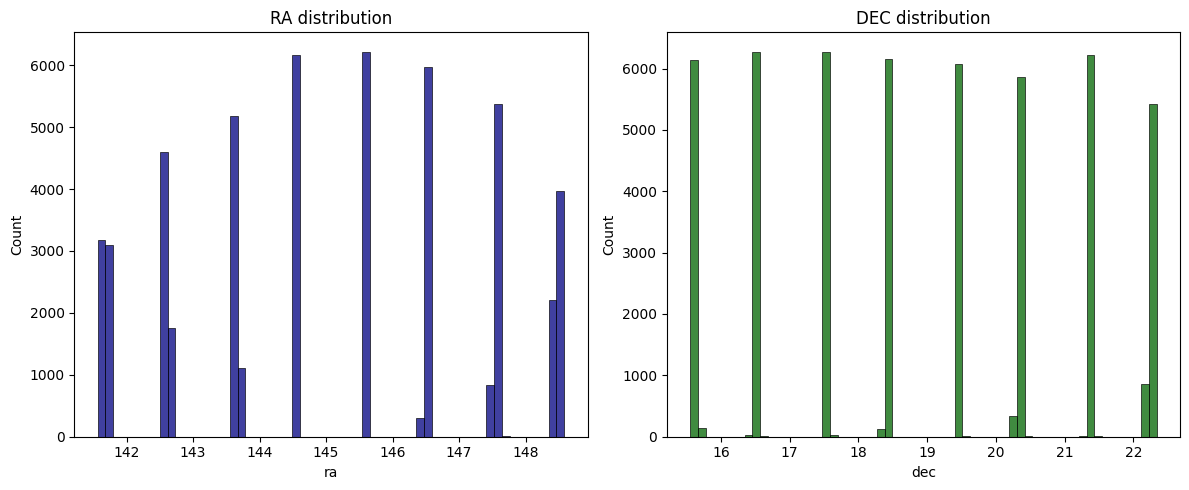

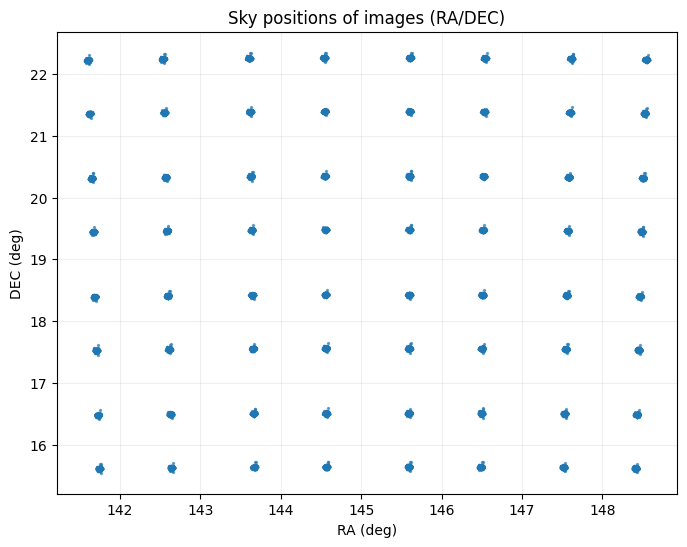

C:\Users\NIPUN\AppData\Local\Temp\ipykernel_20020\3987423046.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df[col], order=df[col].value_counts().index, palette='Set2')


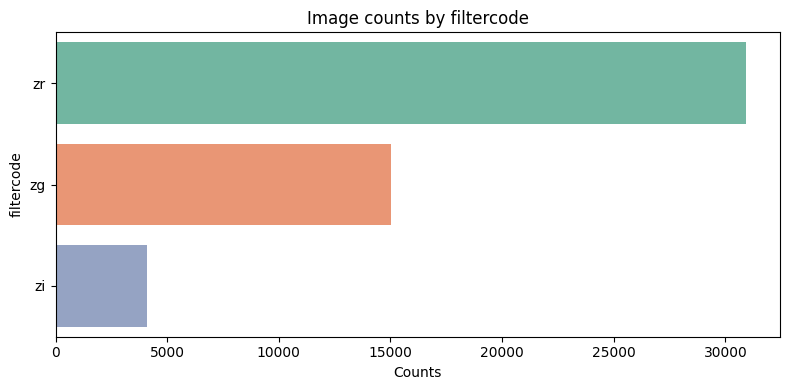


EDA complete - see above charts and counts for quick dataset understanding


In [9]:
# 3) Exploratory Data Analysis (counts, histograms, RA/DEC map, filter distribution)
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

df = pd.read_csv('ztf_image_catalog_subset_cleaned.csv')

# Inspect columns and show first rows
print('Columns:', df.columns.tolist())
display(df.head())

# Top counts for some categorical-like columns if present
for col in ['filtercode', 'filter', 'field', 'ccdid', 'qid', 'rcid', 'fid']:
    if col in df.columns:
        print(f'\nTop values for {col}:')
        print(df[col].value_counts().head(10))

# Histogram of a numeric column (RA / DEC)
if 'ra' in df.columns and 'dec' in df.columns:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sns.histplot(df['ra'].dropna(), bins=60, kde=False, color='navy')
    plt.title('RA distribution')
    plt.subplot(1,2,2)
    sns.histplot(df['dec'].dropna(), bins=60, kde=False, color='darkgreen')
    plt.title('DEC distribution')
    plt.tight_layout()
    plt.show()

# RA/DEC scatter (sky map)
if 'ra' in df.columns and 'dec' in df.columns:
    plt.figure(figsize=(8,6))
    plt.scatter(df['ra'], df['dec'], s=2, alpha=0.6)
    plt.xlabel('RA (deg)')
    plt.ylabel('DEC (deg)')
    plt.title('Sky positions of images (RA/DEC)')
    plt.grid(True, alpha=0.2)
    plt.show()

# Filter distribution plot if filter/filtercode exists
for col in ['filter', 'filtercode']:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.countplot(y=df[col], order=df[col].value_counts().index, palette='Set2')
        plt.title(f'Image counts by {col}')
        plt.xlabel('Counts')
        plt.tight_layout()
        plt.show()

print('\nEDA complete - see above charts and counts for quick dataset understanding')

Model: LogisticRegression - Accuracy: 1.0000
              precision    recall  f1-score   support

          zg       1.00      1.00      1.00      4505
          zi       1.00      1.00      1.00      1225
          zr       1.00      1.00      1.00      9270

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



C:\Users\NIPUN\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


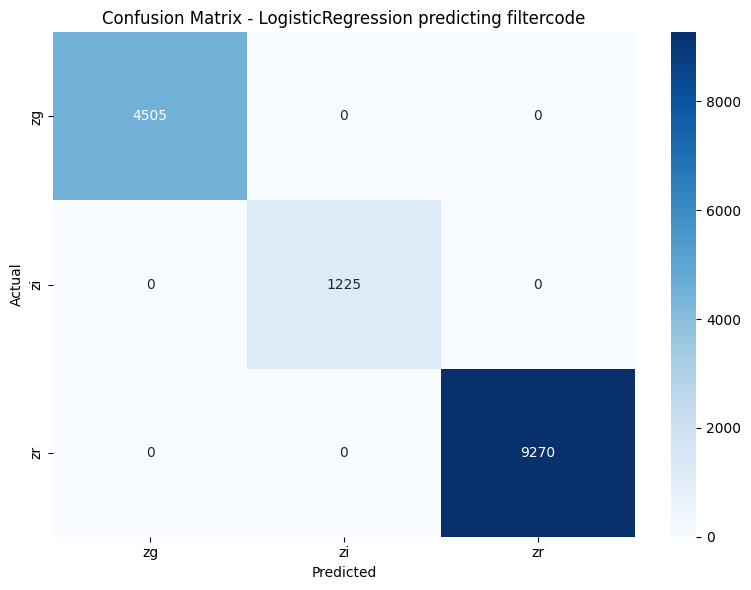

Model: RandomForest - Accuracy: 1.0000
              precision    recall  f1-score   support

          zg       1.00      1.00      1.00      4505
          zi       1.00      1.00      1.00      1225
          zr       1.00      1.00      1.00      9270

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



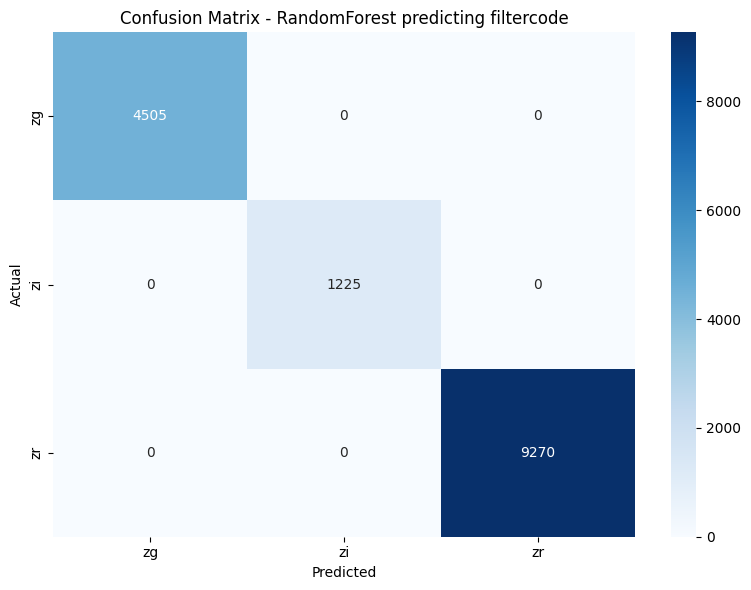

Saved model comparison summary to model_comparison_summary.csv


In [10]:
# 4) Toy classification demo: predict 'filtercode' (or 'filter') from numeric metadata to produce confusion matrix and model comparison
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('ztf_image_catalog_subset_cleaned.csv')
# Choose a target column (prefer 'filter' then 'filtercode')
if 'filter' in df.columns:
    target_col = 'filter'
elif 'filtercode' in df.columns:
    target_col = 'filtercode'
else:
    raise ValueError('No filter-like column found to use as a demo classification target')

# Select feature columns: numeric columns we identified earlier
candidate_features = []
for c in ['ra','dec','field','ccdid','qid','rcid','fid','infobits']:
    if c in df.columns:
        candidate_features.append(c)

if len(candidate_features) == 0:
    raise ValueError('No candidate numeric features available for the toy classifier.')

# Prepare data: drop rows with missing target or features
model_df = df[candidate_features + [target_col]].dropna()
X = model_df[candidate_features].copy()
y = model_df[target_col].copy()

# Encode target
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.3, random_state=42, stratify=y_enc)

# Scale features where appropriate
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit two baseline models and compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=200, multi_class='auto'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}
results = {}
for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    preds = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    print(f"Model: {name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds, target_names=le.classes_))
    results[name] = {'model': clf, 'accuracy': acc, 'preds': preds}
    # Confusion matrix plot
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix - {name} predicting {target_col}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Save model comparison summary to CSV
import pandas as pd
summary_df = pd.DataFrame([{
    'model': m,
    'accuracy': results[m]['accuracy']
} for m in results])
summary_df.to_csv('model_comparison_summary.csv', index=False)
print('Saved model comparison summary to model_comparison_summary.csv')

In [ ]:
# 5) Additional visualizations: feature importances (RandomForest) and PCA/TSNE embedding of metadata
# 5) Additional visualizations: feature importances (RandomForest) and PCA/TSNE embedding of metadata
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load results from previous cell
summary = pd.read_csv('model_comparison_summary.csv')
print('Model comparison:')
print(summary)

# Feature importance from RandomForest (if present)
results = globals().get('results', None)
if results and 'RandomForest' in results and hasattr(results['RandomForest']['model'], 'feature_importances_'):
    rf = results['RandomForest']['model']
    importances = rf.feature_importances_
    feat_names = candidate_features
    fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
    fi_df = fi_df.sort_values('importance', ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
    plt.title('RandomForest Feature Importances')
    plt.tight_layout()
    plt.show()
else:
    print('RandomForest feature importances not available in current session.')

# PCA projection colored by target
df = pd.read_csv('ztf_image_catalog_subset_cleaned.csv')
candidate_features = [c for c in ['ra','dec','field','ccdid','qid','rcid','fid','infobits'] if c in df.columns]
X = df[candidate_features].dropna()
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
pca2 = pca.fit_transform(X_all_scaled)
plt.figure(figsize=(8,6))
plt.scatter(pca2[:,0], pca2[:,1], s=5)
plt.title('PCA of metadata features')
plt.tight_layout()
plt.show()

# TSNE for a smaller sample (to keep runtime reasonable)
sample_size = min(2000, X.shape[0])
idx = np.random.choice(X.shape[0], sample_size, replace=False)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=700)
tsne_emb = tsne.fit_transform(X_all_scaled[idx])
plt.figure(figsize=(8,6))
plt.scatter(tsne_emb[:,0], tsne_emb[:,1], s=5)
plt.title('t-SNE of metadata features (sample)')
plt.tight_layout()
plt.show()

print('Visualization complete.')

#VSC-0601124b
